In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools
from matplotlib.lines import Line2D 
import re
import ast
import os

from scipy.stats import shapiro, levene, wilcoxon, friedmanchisquare, ttest_rel, mannwhitneyu
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.anova import AnovaRM

scripts_folder = os.path.join(os.getcwd(), 'scripts')
print(scripts_folder)

c:\Users\david_vzsxiay\OneDrive - Universidade de Lisboa\P300 Contrastive Learning Project\scripts


In [6]:
def read_and_separate_blocks(filepath, dataset='Intra'):
    """
    Reads a file, separates blocks based on fine_tuning values, and extracts numerical lists.
    This version excludes blocks containing 'Block X Mean' and handles the last block correctly.

    Args:
        filepath (str): Path to the file.

    Returns:
        dict: A dictionary where keys are fine_tuning values, and values are lists of extracted numerical lists.
    """
    blocks = {}
    
    with open(filepath, 'r') as file:
        content = file.read()

    # Adjust the regex to handle the last block correctly
    if dataset == 'Intra':
        r_expression = r"Subject\s+\d+\s+with\s+(\d+)\s+chars\s+retraining(.*?)(?=Subject\s+\d+|$)"
    elif dataset == 'BCI':
        r_expression = r"Subject\s+[A-Z]\s+with\s+(\d+)\s+chars\s+retraining(.*?)(?=Subject\s+[A-Z]|$)"
        
    matches = re.finditer(r_expression, content, re.DOTALL)
    
    for match in matches:
        fine_tuning = int(match.group(1))
        block_data = match.group(2).strip()

        # Extract all lists of numbers in the block
        lists = re.findall(r"\[.*?\]", block_data)
        numerical_lists = [eval(lst) for lst in lists]

        if fine_tuning not in blocks:
            blocks[fine_tuning] = []
        blocks[fine_tuning].append(numerical_lists)
    
    for ft_value, block in blocks.items():
        blocks[ft_value] = np.array(block).reshape(-1, 15)
    
    return blocks

In [7]:
def read_als_file(filepath):
    """
    Reads an ALS file and combines all numerical lists into a single 2D list.

    Args:
        filepath (str): Path to the ALS file.

    Returns:
        list: A 2D list where each inner list is a numerical list from the file.
    """
    combined_lists = []

    with open(filepath, 'r') as file:
        content = file.read()

    # Match numerical lists in the file
    list_pattern = r"\[.*?\]"
    lists = re.findall(list_pattern, content)

    # Parse and combine all lists into a single 2D list
    for lst in lists:
        try:
            numerical_list = ast.literal_eval(lst)  # Safely parse the list
            combined_lists.append(numerical_list)
        except (ValueError, SyntaxError) as e:
            print(f"Error parsing list: {lst}. Skipping. Error: {e}")

    return combined_lists

## BASELINE PERFORMANCES

In [8]:
def plot_baseline_compariosns(file_paths: list, model_names: list):
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    pallete = sns.color_palette(n_colors=8)
    blue, orange, green, red, gray = pallete[0], pallete[1], pallete[2], pallete[3], pallete[7]
    colors = [blue, orange]

    # Static color assignments
    model_colors = {
        'EEGNet Modified': blue, 'EEGNet Original': orange,
        'EEGInception Original': orange,  # Default for EEGInception Original
    }

    plot_groups = {
        0: ['EEGNet Modified', 'EEGNet Original'],
        1: ['EEGInception Modified', 'EEGInception Original'],
    }

    def configure_axis(ax, model):
        ax.set_title(model, fontsize=18)
        ax.set_xlabel("Number of Trials", fontsize=14)
        ax.set_ylabel("Average Accuracy", fontsize=14)
        ax.set_ylim([0, 105])
        ax.set_xticks(range(2, 16, 2))
        ax.tick_params(axis='both', labelsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)

    # Prepare data for statistical analysis
    all_data = {group_idx: {} for group_idx in plot_groups.keys()}
    trial_indices = range(1, 16)

    blocks = {0: [], 1: []}

    for file_path, model_name in zip(file_paths, model_names):
        model_blocks = [key for key, models in plot_groups.items() if model_name in models]
        block = read_and_separate_blocks(file_path, dataset='BCI')

        for key in model_blocks:
            all_data[key][model_name] = block[85]

    # Perform statistical analysis and plot
    for group, group_data in all_data.items():
        means = []
        for i, (key, values) in enumerate(group_data.items()):
            mean = np.mean(values, axis=0)
            means.append(mean)
            axes[group].plot(trial_indices, mean, label=key,
                             color=colors[i], linewidth=2)
        configure_axis(axes[group], list(group_data.keys())[0])
        axes[group].legend(fontsize=12)

        # print(group_data.values())
        trial_results = {trial: [np.array(data)[:, trial] for data in group_data.values()] for trial in range(15)}

        stat_results = []
        significant_trials = []

        # Loop through each trial to perform statistical tests
        for trial, data in trial_results.items():
            print(f'\nN Trials -> {trial+1}')
            trial_data = [d for d in data]

            # Check normality and homogeneity of variance.
            normality = all(shapiro(d).pvalue > 0.05 for d in trial_data)
            homogeneity = levene(*trial_data).pvalue > 0.05
            print(f'\nIs data Normally Distributed? - {normality}')
            print(f'Is Variance Homogeneous? - {homogeneity}')

            # Perform the Mann-Whitney U Test
            stat, p_value = mannwhitneyu(*trial_data, alternative='two-sided')
            print(f'\nMann Whitney U Test results: (F-stat = {stat}, p_value = {p_value})')
            stat_results.append((trial + 1, stat, p_value, "Mann Whitney U Test"))

            # Plot significance lines if p-value is less than 0.05 or 0.01
            if p_value < 0.05:
                # Find the values of the two models a this trial
                first_model = list(group_data.keys())[0]
                second_model = list(group_data.keys())[0]
                
                y_val_i = means[0][trial] 
                y_val_j = means[1][trial] 

                y_buffer = (max(means[0]) - min(means[0])) * 0.05
                
                # Set the line color based on p-value
                line_color = "gray" if p_value < 0.01 else "red"

                # Plot the significance line between the two models' values at this trial
                axes[group].plot([trial+1, trial+1], 
                                          [min(y_val_i, y_val_j) - y_buffer, max(y_val_i, y_val_j) + y_buffer], 
                                          color=line_color, linestyle='-', alpha=0.7, linewidth=2)

    red_line = Line2D([0], [0], color=red, lw=2, linestyle='-', label='p < 0.05')
    black_line = Line2D([0], [0], color=gray, lw=2, linestyle='-', label='p < 0.01')
    fig.legend(handles=[black_line, red_line], loc='upper right', fontsize=12, title="Significance", title_fontsize=14, bbox_to_anchor=(0.99, 0.99))
    
    plt.suptitle('Performance Comparison Between Original and Modified Models', fontsize=20, y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.92]) 
    plt.show()


In [9]:
import math
def compute_ITR(accuracy, n_trials, dataset='BCI'):
    N = 36
    T = 2.5 + 2.1*n_trials if dataset == 'BCI' else 2.5 + 3*n_trials
    
    term1 = math.log2(N)
    term2 = accuracy * math.log2(accuracy)
    term3 = (1-accuracy) * math.log2((1-accuracy) / (N-1))
    
    itr = (term1 + term2 + term3) * 60 / T
    return itr

In [10]:
def plot_baseline(file_paths: list, model_names: list, dataset='BCI'):
    # Setup the figure
    fig, ax = plt.subplots(figsize=(12, 6))
    palette = sns.color_palette(n_colors=8)
    blue, orange, green, red, purple, gray = palette[0], palette[1], palette[2], palette[3], palette[4], palette[7]
    
    trial_indices = range(1,16) if dataset == 'BCI' else range(1,11)
    
    # Model Colors and Plot groups
    # model_colors = {
    #     'EEGNet': blue, 'EEGInception': orange, 'Conformer': green
    # }

    model_colors = [blue, orange, green, red, purple, gray]

    # Prepare data for statistical analysis
    all_data = {model_name: [] for model_name in model_names}

    for file_path, model_name in zip(file_paths, model_names):
        if dataset == 'BCI':
            block = read_and_separate_blocks(file_path, dataset='BCI')
            # print(block)
            all_data[model_name] = block[85]  # Assuming block[85] holds the required accuracy data
        elif dataset == 'ALS':
            block = read_als_file(file_path)
            all_data[model_name] = block

    # Perform Friedman's test on all trials
    trial_results = {trial-1: [np.array(all_data[model_name])[:, trial-1] for model_name in model_names] for trial in trial_indices}
    friedman_results = []
    p_values = []

    # Perform Friedman's test across all trials
    for trial, data in trial_results.items():
        stat, p_value = friedmanchisquare(*data)
        friedman_results.append((trial + 1, stat, p_value))
        p_values.append(p_value)

    # Wilcoxon post-hoc test
        if p_value < 0.05:
            p_values_wilcoxon = []
            pairs = list(itertools.combinations(range(len(data)), 2))  
            adjusted_p_values = []
            
            for (i, j) in pairs:
                stat, p_value_wilcoxon = wilcoxon(data[i], data[j])
                p_values_wilcoxon.append((i, j, p_value_wilcoxon))
                    
            # Apply Benjamini-Hochberg correction
            sorted_p_values = sorted(p_values_wilcoxon, key=lambda x: x[2])  # Sort by p-value
            m = len(sorted_p_values)  # Total number of tests
                    
            for k, (i, j, p) in enumerate(sorted_p_values):
                adjusted_p = p * m / (k + 1)
                adjusted_p = min(adjusted_p, 1)  # Ensure adjusted p-value does not exceed 1
                adjusted_p_values.append((i, j, adjusted_p))
                
            print(f"\nPost-hoc Wilcoxon tests for trial {trial + 1}:")
            for (i, j, adj_p_value) in adjusted_p_values:
                print(f"Wilcoxon test between {model_names[i]} and {model_names[j]}: p-value = {adj_p_value}")

    ax2 = ax.twinx()
    ax2.set_ylabel("ITR (bits/min)", fontsize=14, color='gray')
    ax2.set_ylim([0, 13])
    ax2.set_yticks(range(0, 13, 3))
    ax2.tick_params(axis='y', labelsize=12, colors='gray')
    ax2.grid(False)
    
    # Plotting the mean of each model
    for i, model_name in enumerate(model_names):
        mean = np.mean(all_data[model_name], axis=0)
        print(f'{model_name}: \nMean = {mean}')
        ax.plot(trial_indices, mean, label=model_name, color=model_colors[i], linewidth=2)
        
        itr_values = [compute_ITR(acc/100, trial+1, dataset) for trial, acc in enumerate(mean)]
        print(f'\n{itr_values}')
        ax2.plot(trial_indices, itr_values, label=f'{model_name} ITR', color=model_colors[i], linestyle='dotted')

    # Configure axis and title
    ax.set_xlabel("Number of Trials", fontsize=14)
    ax.set_ylabel("Average Accuracy", fontsize=14)
    ax.set_ylim([0, 105])
    ax.set_xticks(trial_indices)
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=12)
    ax.set_title(f'{dataset} Dataset\nPerformance Comparison Between Models Across Trials', fontsize=18)

    plt.tight_layout(rect=[0, 0, 1, 0.92]) 
    plt.show()


Post-hoc Wilcoxon tests for trial 1:
Wilcoxon test between EEGInception and Conformer: p-value = 1.1561547993493218e-06
Wilcoxon test between EEGNet and Conformer: p-value = 1.2492074464319978e-05
Wilcoxon test between EEGNet and EEGInception: p-value = 0.3419995576934111

Post-hoc Wilcoxon tests for trial 2:
Wilcoxon test between EEGNet and Conformer: p-value = 3.38916735193084e-14
Wilcoxon test between EEGInception and Conformer: p-value = 1.4624216688848689e-07
Wilcoxon test between EEGNet and EEGInception: p-value = 3.808645212942071e-06

Post-hoc Wilcoxon tests for trial 3:
Wilcoxon test between EEGNet and Conformer: p-value = 2.1976010198583166e-13
Wilcoxon test between EEGInception and Conformer: p-value = 6.229636697018064e-07
Wilcoxon test between EEGNet and EEGInception: p-value = 7.38883639662201e-05

Post-hoc Wilcoxon tests for trial 4:
Wilcoxon test between EEGNet and Conformer: p-value = 8.661624027378349e-16
Wilcoxon test between EEGNet and EEGInception: p-value = 1.487

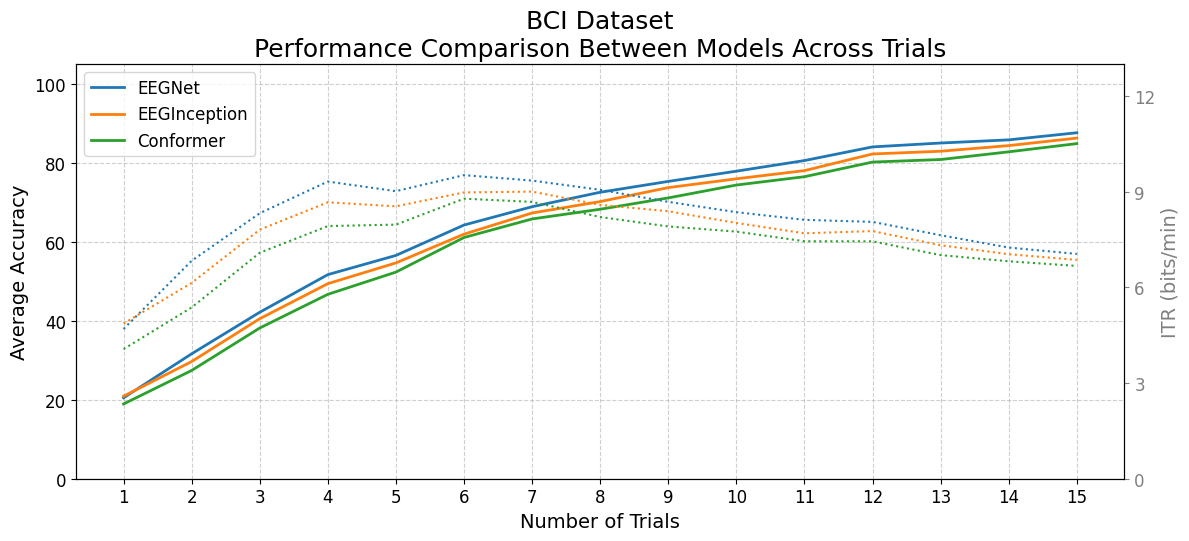

In [15]:
files = [
    os.path.join(scripts_folder, 'CrossEvaluation/Baseline Results/EEGNet_results/EEGNet_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/Baseline Results/EEGInception_results/EEGInception_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/Baseline Results/Conformer_results/Conformer_50Folfd_evaluation_results.txt'),
]

model_names = ['EEGNet', 'EEGInception', 'Conformer']

plot_baseline(files, model_names)


Post-hoc Wilcoxon tests for trial 1:
Wilcoxon test between EEGNet and EEGNet SimCLR: p-value = 1.6283628165924253e-22
Wilcoxon test between EEGInception and EEGNet SimCLR: p-value = 3.3418141001547317e-19
Wilcoxon test between EEGInception and Conformer: p-value = 8.72251778245689e-08
Wilcoxon test between Conformer and EEGNet SimCLR: p-value = 1.5503488289076415e-07
Wilcoxon test between EEGNet and Conformer: p-value = 0.0002568102057783982
Wilcoxon test between EEGNet and EEGInception: p-value = 0.11832887976810479

Post-hoc Wilcoxon tests for trial 2:
Wilcoxon test between EEGNet and EEGNet SimCLR: p-value = 1.1664568435169125e-59
Wilcoxon test between EEGInception and EEGNet SimCLR: p-value = 1.0809838308615467e-53
Wilcoxon test between Conformer and EEGNet SimCLR: p-value = 4.836393417231672e-22
Wilcoxon test between EEGNet and Conformer: p-value = 1.9842516335086805e-15
Wilcoxon test between EEGInception and Conformer: p-value = 3.7492042030641994e-14
Wilcoxon test between EEGNe

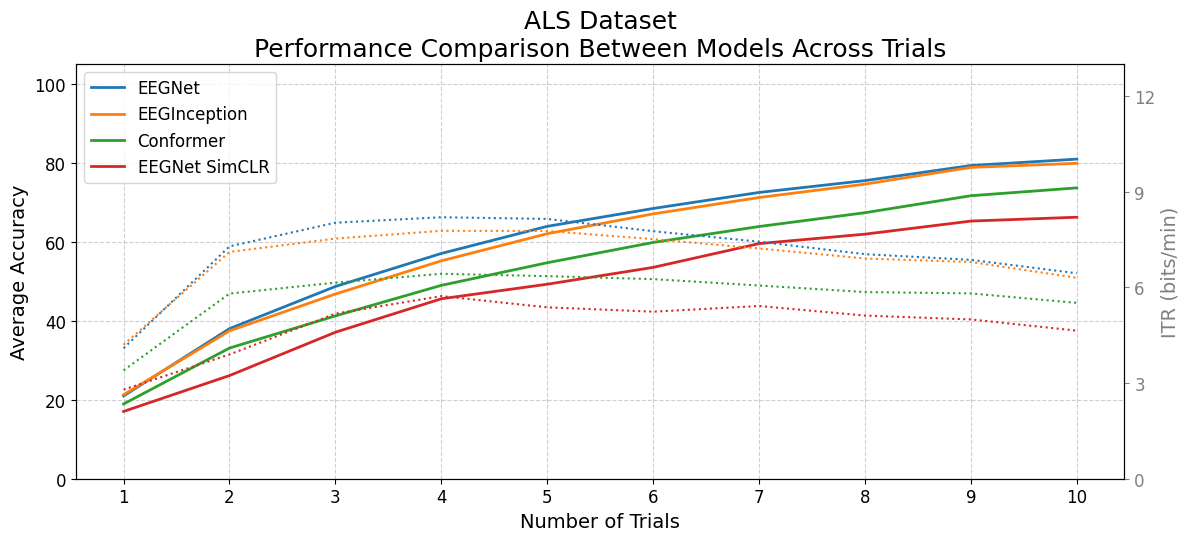

In [16]:
files = [
    os.path.join(scripts_folder, 'CrossEvaluation/Baseline Results/EEGNet_results_ALS/EEGNet_50Folfd_evaluation_results_ALS.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/Baseline Results/EEGInception_results_ALS/EEGInception_50Folfd_evaluation_results_ALS.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/Baseline Results/Conformer_results_ALS/Conformer_50Folfd_evaluation_results_ALS.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/ALS Results/SimCLR_results/EEGNet_1CLS_50Folfd_evaluation_results.txt')
]

model_names = ['EEGNet', 'EEGInception', 'Conformer', 'EEGNet SimCLR']

plot_baseline(files, model_names, dataset='ALS')


N Trials -> 1

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Mann Whitney U Test results: (F-stat = 4872.0, p_value = 0.7548063563663994)

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - True

Mann Whitney U Test results: (F-stat = 5422.5, p_value = 0.30150746782788995)

N Trials -> 3

Is data Normally Distributed? - False
Is Variance Homogeneous? - True

Mann Whitney U Test results: (F-stat = 4486.0, p_value = 0.20878407787747622)

N Trials -> 4

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Mann Whitney U Test results: (F-stat = 4304.5, p_value = 0.08869898573079957)

N Trials -> 5

Is data Normally Distributed? - False
Is Variance Homogeneous? - True

Mann Whitney U Test results: (F-stat = 4135.5, p_value = 0.03437457393783475)

N Trials -> 6

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Mann Whitney U Test results: (F-stat = 4707.5, p_value = 0.4745167872772321)

N Trials

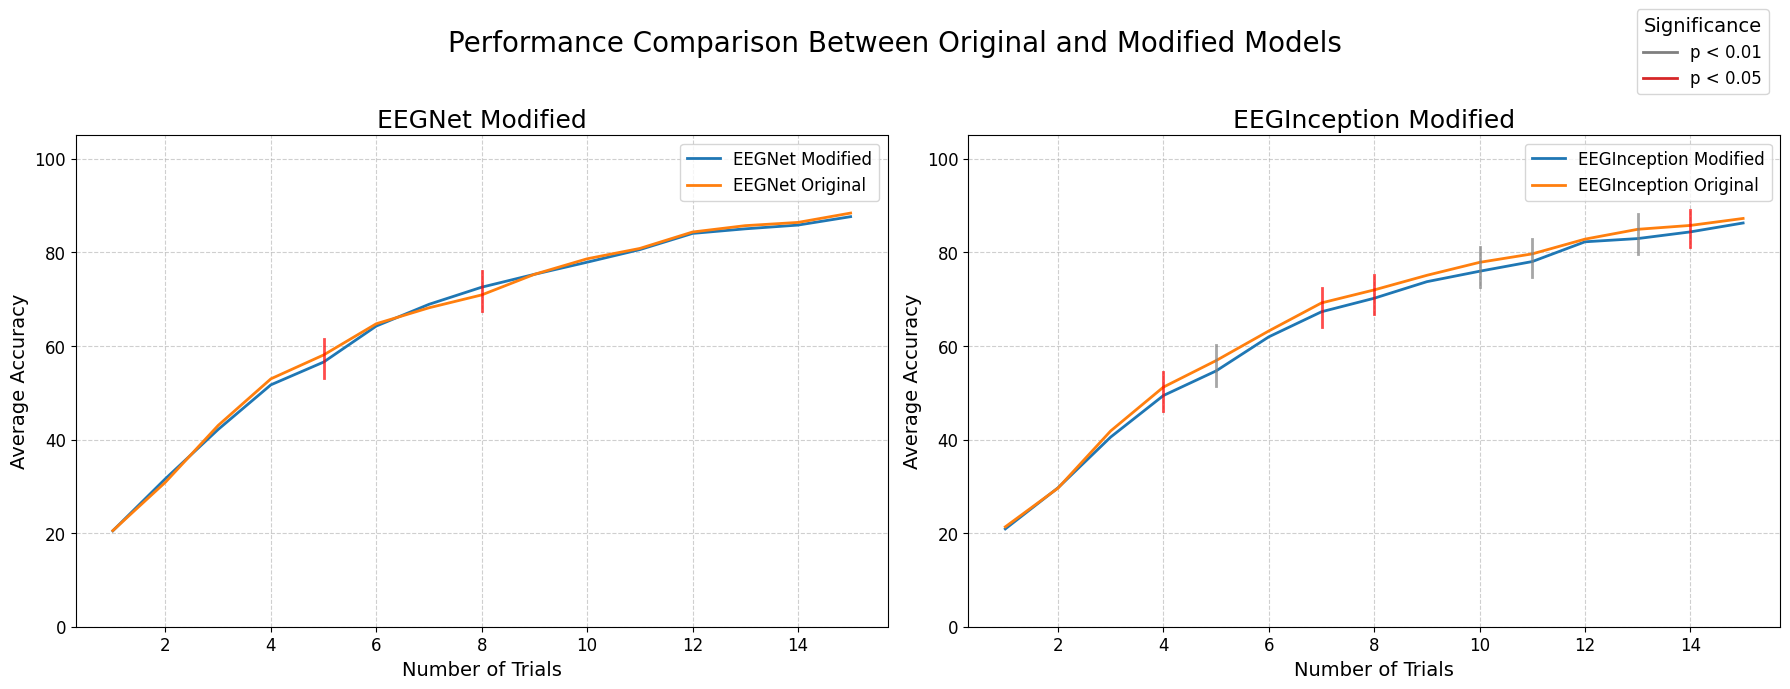

In [17]:
files = [
    os.path.join(scripts_folder, 'CrossEvaluation/Baseline Results/EEGNet_results/EEGNet_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/Baseline Results/EEGNet_Original_results/EEGNet_Original_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/Baseline Results/EEGInception_results/EEGInception_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/Baseline Results/EEGInception_Original_results/EEGInception_Original_50Folfd_evaluation_results.txt'),
    # os.path.join(scripts_folder, 'CrossEvaluation/Baseline Results/Conformer_results/Conformer_50Folfd_evaluation_results.txt'
]

model_names = ['EEGNet Modified', 'EEGNet Original', 'EEGInception Modified', 'EEGInception Original']

plot_baseline_compariosns(files, model_names)

## INTRA EVALUATION

In [18]:
def parse_file(filename):
    results = []
    with open(filename, 'r') as file:
        block = []
        for line in file:
            line = line.strip()
            if line.startswith('Subject'):
                if block:  # If there's an existing block, calculate its mean
                    block_mean = np.round(np.mean(block, axis=0), 2)
                    results.append(block_mean)
                    block = []
            elif line.startswith('['):
                data = eval(line)  # Convert string to list
                block.append(data)
        if block:  # Process the last block
            block_mean = np.round(np.mean(block, axis=0), 2)
            results.append(block_mean)
    return results

def compute_group_statistics(data, indices):
    """Compute mean and std for specific subject groups."""
    group_data = np.array(data)[indices]
    group_mean = np.round(np.mean(group_data, axis=0), 2)
    group_std = np.round(np.std(group_data, axis=0), 2)
    return group_mean, group_std

def format_mean_std(mean, std, indices=range(15)):
    # Format as "mean ± std"
    return ' & '.join([f'{mean[i]} ± {std[i]}' for i in indices])

# Usage
# filename = "/workspace/project/GitHub/newScripts/IntraEvaluation/Supervised_results/EEGNet_1CLS_evaluation_results.txt" 
filename = os.path.join(scripts_folder, 'IntraEvaluation/SupCon_results/EEGNet_1CLS_evaluation_results.txt')
block_averages = parse_file(filename)

for i, mean in enumerate(block_averages, 1):
    print(f"Block {i} Mean: {list(mean)}")

# Define subject indices
num_control_subjects = 7
num_motor_disabled_subjects = 7
control_indices = list(range(num_control_subjects))  # First 7 subjects
motor_disabled_indices = list(range(num_control_subjects, num_control_subjects + num_motor_disabled_subjects))  # Last 7 subjects
overall_indices = list(range(num_control_subjects + num_motor_disabled_subjects))  # All subjects


# Compute statistics
ft_values = [1, 5, 10]
for i in range(len(ft_values)):
    print(f'Performance for {ft_values[i]} chars')
    control_mean, control_std = compute_group_statistics(block_averages[i*14:(i+1)*14], control_indices)
    motor_disabled_mean, motor_disabled_std = compute_group_statistics(block_averages[i*14:(i+1)*14], motor_disabled_indices)
    overall_mean, overall_std = compute_group_statistics(block_averages[i*14:(i+1)*14], overall_indices)

    # Print results
    print("Performance Analysis:")
    print(f"Control Subjects: {format_mean_std(control_mean, control_std)}")
    print(f"Motor-Disabled Subjects: {format_mean_std(motor_disabled_mean, motor_disabled_std)}")
    print(f"Overall (Control + Motor-Disabled): {format_mean_std(overall_mean, overall_std)}")

print()

selected_indices = [0, 4, 9, 14]
for i in range(len(ft_values)):
    print()
    print(f'Performance for {ft_values[i]} chars')
    control_mean, control_std = compute_group_statistics(block_averages[i*14:(i+1)*14], control_indices)
    motor_disabled_mean, motor_disabled_std = compute_group_statistics(block_averages[i*14:(i+1)*14], motor_disabled_indices)
    overall_mean, overall_std = compute_group_statistics(block_averages[i*14:(i+1)*14], overall_indices)

    # Print results
    print("Performance Analysis:")
    print(f"Control Subjects: {format_mean_std(control_mean, control_std, selected_indices)}")
    print(f"Motor-Disabled Subjects: {format_mean_std(motor_disabled_mean, motor_disabled_std, selected_indices)}")
    print(f"Overall (Control + Motor-Disabled): {format_mean_std(overall_mean, overall_std, selected_indices)}")

Block 1 Mean: [19.79, 33.12, 40.3, 51.63, 60.07, 68.68, 73.83, 77.76, 80.41, 82.51, 86.14, 88.41, 89.22, 90.48, 92.27]
Block 2 Mean: [8.88, 11.96, 14.98, 16.37, 18.91, 21.46, 22.58, 25.02, 27.15, 29.63, 31.59, 33.05, 33.59, 34.1, 34.41]
Block 3 Mean: [12.1, 18.44, 22.57, 29.76, 34.24, 36.58, 41.69, 46.0, 48.81, 52.47, 53.66, 56.34, 59.19, 60.2, 63.29]
Block 4 Mean: [29.39, 44.2, 55.05, 64.24, 70.51, 74.85, 80.41, 84.51, 84.44, 87.59, 90.37, 91.43, 92.31, 92.99, 93.56]
Block 5 Mean: [14.68, 28.27, 36.68, 46.75, 53.73, 54.92, 59.19, 63.76, 67.05, 70.34, 72.17, 76.88, 76.65, 76.61, 77.83]
Block 6 Mean: [12.57, 24.68, 33.93, 43.63, 47.73, 53.97, 57.93, 61.39, 64.88, 65.49, 66.61, 70.37, 72.14, 75.83, 76.68]
Block 7 Mean: [9.49, 14.54, 19.22, 20.47, 23.15, 26.41, 28.51, 32.88, 35.36, 37.22, 38.68, 40.34, 41.46, 43.52, 45.02]
Block 8 Mean: [5.8, 6.13, 7.56, 8.03, 8.81, 9.05, 10.78, 11.79, 12.07, 12.81, 13.08, 12.85, 13.52, 14.27, 14.74]
Block 9 Mean: [21.05, 28.58, 36.37, 43.45, 50.89, 53.75

In [19]:
def get_differences(file_paths:list, model, retraining_chars = [1, 5, 10], dataset='Intra'):
    
    strategies = ['Supervised', 'SimCLR', 'SupCon']
    subjects = ['MD SUBJECTS', 'CONTROL SUBJECTS', 'ALL SUBJECTS']
    trials_analysed = range(15)
    
    md_subjects_data = {i: [] for i in retraining_chars}
    control_subjects_data = {i: [] for i in retraining_chars}
    all_subjects_data = {i: [] for i in retraining_chars}
    
    data = [md_subjects_data, control_subjects_data, all_subjects_data] if dataset == 'Intra' else [all_subjects_data]
    
    for file_path in file_paths:
        blocks = read_and_separate_blocks(file_path, dataset)
        for n_char in retraining_chars:
            control_subjects_data[n_char].append(blocks[n_char][:350]) if dataset == 'Intra' else None
            md_subjects_data[n_char].append(blocks[n_char][350:]) if dataset == 'Intra' else None
            all_subjects_data[n_char].append(blocks[n_char])
    
    for sub, retraining_char_dict in enumerate(data):   
        
        sub = 2 if dataset == 'BCI'else sub
        print(f'\n{subjects[sub]}\n')
        
        for retraining_idx, (retraining_char, reatraining_data) in enumerate(retraining_char_dict.items()):
            
            means = [np.mean(d, axis=0) for d in reatraining_data]
            # print(means)
            std_deviations = [np.std(d, axis=0) for d in reatraining_data]
            
            print(f'Analysing data from {retraining_char} Retraining Chars')
            trial_results = {trial: [np.array(model)[:, trial] for model in reatraining_data] for trial in trials_analysed}
            
            friedman_results = []
            differences = {'SimCLR': [], 'SupCon': []}
    
            
            for trial, data in trial_results.items():
                print(f'\nN Trials -> {trial+1}')
                trial_data = [d for d in data]
                
                # Check normality and homogeneity of variance.
                normality = all(shapiro(d).pvalue > 0.05 for d in trial_data)
                homogeneity = levene(*trial_data).pvalue > 0.05
                print(f'\nIs data Normally Distributed? - {normality}')
                print(f'Is Variance Homogeneous? - {homogeneity}')
                
                f_stat, p_value = friedmanchisquare(*trial_data)
                print(f'\nFriedman Test results: (F-stat = {f_stat}, p_value = {p_value})')
                friedman_results.append((trial + 1, f_stat, p_value, "Friedman Test"))
                
                # Wilcoxon post-hoc test
                if p_value < 0.05:
                    p_values = []
                    pairs = list(itertools.combinations(range(len(trial_data)), 2))  
                    adjusted_p_values = []
                    
                    for (i, j) in pairs:
                        stat, p_value_wilcoxon = wilcoxon(trial_data[i], trial_data[j])
                        p_values.append((i, j, p_value_wilcoxon))
                        
                    # Apply Benjamini-Hochberg correction
                    sorted_p_values = sorted(p_values, key=lambda x: x[2])  # Sort by p-value
                    m = len(sorted_p_values)  # Total number of tests
                    
                        
                    for k, (i, j, p) in enumerate(sorted_p_values):
                        adjusted_p = p * m / (k + 1)
                        adjusted_p = min(adjusted_p, 1)  # Ensure adjusted p-value does not exceed 1
                        adjusted_p_values.append((i, j, adjusted_p))
                            
                    
                    print(f"Post-hoc Wilcoxon tests for trial {trial + 1}:")
                    
                    for (i, j, adj_p_value) in adjusted_p_values:
                        diff = means[j][trial] - means[i][trial]
                        print(f"Wilcoxon test between {strategies[j]} and {strategies[i]}: p-value = {adj_p_value}: diff -> {means[j][trial]:.2f} - {means[i][trial]:.2f} = {diff:.2f}")
                        if adj_p_value < 0.05 and strategies[i] == 'Supervised':
                            differences[strategies[j]].append(diff)
                            
            print(f'\n {subjects[sub]} Differences {retraining_char}: {differences}')
            print(f'\nAverage Difference: ({np.mean(differences["SimCLR"]):.2f}, {np.mean(differences["SupCon"]):.2f})\n')   
            
    

In [20]:
file_paths = [
    os.path.join(scripts_folder, 'IntraEvaluation/Supervised_results/EEGNet_1CLS_evaluation_results.txt'),
    os.path.join(scripts_folder, 'IntraEvaluation/SimCLR_results/EEGNet_1CLS_evaluation_results.txt'),
    os.path.join(scripts_folder, 'IntraEvaluation/SupCon_results/EEGNet_1CLS_evaluation_results.txt')
]
eegnet_fig = get_differences(file_paths, 'EEGNet')


MD SUBJECTS

Analysing data from 1 Retraining Chars

N Trials -> 1

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 224.45229151014308, p_value = 1.823073479209744e-49)
Post-hoc Wilcoxon tests for trial 1:
Wilcoxon test between SupCon and SimCLR: p-value = 1.771063839664356e-40: diff -> 17.53 - 8.54 = 9.00
Wilcoxon test between SimCLR and Supervised: p-value = 2.7184975917937843e-40: diff -> 8.54 - 18.67 = -10.13
Wilcoxon test between SupCon and Supervised: p-value = 0.013053048767385179: diff -> 17.53 - 18.67 = -1.13

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 231.9895209580835, p_value = 4.2083862625532065e-51)
Post-hoc Wilcoxon tests for trial 2:
Wilcoxon test between SimCLR and Supervised: p-value = 3.983507788547528e-45: diff -> 10.63 - 25.67 = -15.04
Wilcoxon test between SupCon and SimCLR: p-value = 6.944516281421997e-41: diff -> 23.50 - 10.63 = 

c:\Users\david_vzsxiay\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\david_vzsxiay\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Average Difference: (-30.34, nan)

Analysing data from 5 Retraining Chars

N Trials -> 1

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 346.37776085300817, p_value = 6.095718509428753e-76)
Post-hoc Wilcoxon tests for trial 1:
Wilcoxon test between SupCon and SimCLR: p-value = 2.282917474136592e-49: diff -> 23.57 - 14.26 = 9.31
Wilcoxon test between SimCLR and Supervised: p-value = 5.0219263163363794e-42: diff -> 14.26 - 21.02 = -6.76
Wilcoxon test between SupCon and Supervised: p-value = 6.66909136211445e-12: diff -> 23.57 - 21.02 = 2.55

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 483.5364238410592, p_value = 1.0032280427900515e-105)
Post-hoc Wilcoxon tests for trial 2:
Wilcoxon test between SupCon and SimCLR: p-value = 1.4226764610268682e-57: diff -> 40.56 - 23.55 = 17.00
Wilcoxon test between SimCLR and Supervised: p-value = 1.2518669590326987e-56: 

In [21]:
file_paths = [
    os.path.join(scripts_folder, 'IntraEvaluation/Supervised_results/EEGInception_1CLS_evaluation_results.txt'),
    os.path.join(scripts_folder, 'IntraEvaluation/SimCLR_results/EEGInception_1CLS_evaluation_results.txt'),
    os.path.join(scripts_folder, 'IntraEvaluation/SupCon_results/EEGInception_1CLS_evaluation_results.txt')
]
eeginception_fig = get_differences(file_paths, 'EEGInception')


MD SUBJECTS

Analysing data from 1 Retraining Chars

N Trials -> 1

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 313.42520265291085, p_value = 8.721315530518831e-69)
Post-hoc Wilcoxon tests for trial 1:
Wilcoxon test between SimCLR and Supervised: p-value = 1.52783529305904e-51: diff -> 6.50 - 20.67 = -14.18
Wilcoxon test between SupCon and SimCLR: p-value = 4.9391466459985886e-39: diff -> 15.34 - 6.50 = 8.84
Wilcoxon test between SupCon and Supervised: p-value = 7.254620782387343e-22: diff -> 15.34 - 20.67 = -5.33

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 348.63025830258266, p_value = 1.9765203827643648e-76)
Post-hoc Wilcoxon tests for trial 2:
Wilcoxon test between SimCLR and Supervised: p-value = 3.037518211927882e-53: diff -> 8.15 - 28.30 = -20.15
Wilcoxon test between SupCon and SimCLR: p-value = 1.809545455211547e-41: diff -> 20.99 - 8.15 = 1

In [22]:
file_paths = [
    os.path.join(scripts_folder, 'IntraEvaluation/Supervised_results/Conformer_1CLS_evaluation_results.txt'),
    os.path.join(scripts_folder, 'IntraEvaluation/SimCLR_results/Conformer_1CLS_evaluation_results.txt'),
    os.path.join(scripts_folder, 'IntraEvaluation/SupCon_results/Conformer_1CLS_evaluation_results.txt')
]
conformer_fig = get_differences(file_paths, 'Conformer')


MD SUBJECTS

Analysing data from 1 Retraining Chars

N Trials -> 1

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 256.04932735426013, p_value = 2.5095451724696854e-56)
Post-hoc Wilcoxon tests for trial 1:
Wilcoxon test between SimCLR and Supervised: p-value = 3.066460999657657e-45: diff -> 8.10 - 17.80 = -9.70
Wilcoxon test between SupCon and SimCLR: p-value = 8.055561557783934e-40: diff -> 16.92 - 8.10 = 8.82
Wilcoxon test between SupCon and Supervised: p-value = 0.12729215051643236: diff -> 16.92 - 17.80 = -0.88

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 259.00371195248664, p_value = 5.728732628027825e-57)
Post-hoc Wilcoxon tests for trial 2:
Wilcoxon test between SimCLR and Supervised: p-value = 2.0260990025379234e-44: diff -> 10.49 - 24.39 = -13.91
Wilcoxon test between SupCon and SimCLR: p-value = 6.894742690881083e-43: diff -> 23.14 - 10.49 = 1

In [ ]:
from PIL import Image
# Load the images
image1 = Image.open("/workspace/project/intraEEGNet.png")
image2 = Image.open("/workspace/project/intraEEGInception.png")
image3 = Image.open("/workspace/project/intraConformer.png")

# Get dimensions of the images
widths, heights = zip(*(img.size for img in [image1, image2, image3]))
max_width = max(widths)
total_height = sum(heights)

# Create a blank canvas for the vertical stack
combined_image = Image.new("RGB", (max_width, total_height))

# Paste images on top of each other
y_offset = 0
for img in [image1, image2, image3]:
    combined_image.paste(img, (0, y_offset))
    y_offset += img.height

# Save the combined image
combined_image.save("combined_image_vertical.png")

In [49]:
def statistical_analysis_Intra(file_paths:list, model, retraining_chars = [1, 5, 10], dataset='Intra'):
    strategies = ['Supervised', 'SimCLR', 'SupCon']
    
    # Create a larger figure for publication-quality plots
    if len(retraining_chars)<=3:
        fig, axes = plt.subplots(1, len(retraining_chars), figsize=(18, 6)) 
    else:
        fig, axes = plt.subplots(2, len(retraining_chars) // 2, figsize=(18, 12)) 
    axes = axes.flatten()
    
    retraining_char_dict = {i: [] for i in retraining_chars}
    # print(retraining_char_dict)
    
    for file_path in file_paths:
        blocks = read_and_separate_blocks(file_path, dataset)
        # print(blocks)
        for n_char in retraining_chars:
            retraining_char_dict[n_char].append(blocks[n_char])
        
        
    for retraining_idx, (retraining_char, reatraining_data) in enumerate(retraining_char_dict.items()):
        
        means = [np.mean(d, axis=0) for d in reatraining_data]
        std_deviations = [np.std(d, axis=0) for d in reatraining_data]
        
        print(f'Analysing data from {retraining_char} Retraining Chars')
        trial_results = {trial: [np.array(model)[:, trial] for model in reatraining_data] for trial in range(15)}
        
        friedman_results = []
        significant_trials = []  # To store significant trials for strategy 0 vs 2
        
        for trial, data in trial_results.items():
            print(f'\nN Trials -> {trial+1}')
            trial_data = [d for d in data]
            
            # Check normality and homogeneity of variance.
            normality = all(shapiro(d).pvalue > 0.05 for d in trial_data)
            homogeneity = levene(*trial_data).pvalue > 0.05
            print(f'\nIs data Normally Distributed? - {normality}')
            print(f'Is Variance Homogeneous? - {homogeneity}')
            
            f_stat, p_value = friedmanchisquare(*trial_data)
            print(f'\nFriedman Test results: (F-stat = {f_stat}, p_value = {p_value})')
            friedman_results.append((trial + 1, f_stat, p_value, "Friedman Test"))
            
            # Wilcoxon post-hoc test
            if p_value < 0.05:
                p_values = []
                pairs = list(itertools.combinations(range(len(trial_data)), 2))  
                adjusted_p_values = []
                
                for (i, j) in pairs:
                    stat, p_value_wilcoxon = wilcoxon(trial_data[i], trial_data[j])
                    p_values.append((i, j, p_value_wilcoxon))
                    
                # Apply Benjamini-Hochberg correction
                sorted_p_values = sorted(p_values, key=lambda x: x[2])  # Sort by p-value
                m = len(sorted_p_values)  # Total number of tests
                
                    
                for k, (i, j, p) in enumerate(sorted_p_values):
                    adjusted_p = p * m / (k + 1)
                    adjusted_p = min(adjusted_p, 1)  # Ensure adjusted p-value does not exceed 1
                    adjusted_p_values.append((i, j, adjusted_p))
                        
                
                print(f"Post-hoc Wilcoxon tests for trial {trial + 1}:")
                for (i, j, adj_p_value) in adjusted_p_values:
                    print(f"Wilcoxon test between {strategies[i]} and {strategies[j]}: p-value = {adj_p_value}")
                    # if dataset == 'Intra' and i == 0 and j == 2 and adj_p_value < 0.05:
                        # Add only significant trials involving the top two strategies
                    top_two_indices = np.argsort([means[s][trial] for s in range(len(strategies))])[-2:]
                    if i in top_two_indices and j in top_two_indices and adj_p_value < 0.05:
                        significant_trials.append((trial + 1, i, j, adj_p_value))
                        # significant_trials.append((trial + 1, i, j, adj_p_value))
    
        pallete = sns.color_palette(n_colors=8)
        blue, orange, green, red, gray = pallete[0], pallete[1], pallete[2], pallete[3], pallete[7]
        colors = [orange, green, blue]

        # Plot results
        for strategy_idx, (strategy, color) in enumerate(zip(strategies, colors)):
            axes[retraining_idx].plot(range(1, 16), means[strategy_idx], label=strategy, color=color, linewidth=2)
        
        # Only add vertical lines for significant differences between strategy 0 and 2
        for trial, i, j, p_value in significant_trials:
            if p_value < 0.05:  # For significance at p < 0.05
                # Get the values for strategy 0 and 2 at this trial
                y_val_i = means[0][trial - 1]  # Supervised (Strategy 0)
                y_val_j = means[2][trial - 1]  # SupCon (Strategy 2)
                
                # Calculate a small buffer to extend the line beyond the two points
                y_buffer = (max(means[0]) - min(means[0])) * 0.05  # Extend 5% of the range
                
                # Set the line color based on the p-value
                line_color = gray if p_value < 0.01 else red
                
                # Plot a vertical line from y_val_0 to y_val_2, with a buffer above and below
                axes[retraining_idx].plot([trial, trial], 
                                          [min(y_val_i, y_val_j) - y_buffer, max(y_val_i, y_val_j) + y_buffer], 
                                          color=line_color, linestyle='-', alpha=0.7, linewidth=2)
        
        axes[retraining_idx].set_title(f"N = {retraining_chars[retraining_idx]}", fontsize=16)
        axes[retraining_idx].set_xlabel("Number of Trials", fontsize=14)
        axes[retraining_idx].set_ylabel("Average Accuracy", fontsize=14)
        axes[retraining_idx].set_ylim([0, 105])
        axes[retraining_idx].set_xticks([2, 4, 6, 8, 10, 12, 14])
        axes[retraining_idx].tick_params(axis='both', labelsize=12)
        axes[retraining_idx].grid(True, linestyle='--', alpha=0.6)
        axes[retraining_idx].legend(fontsize=12)
        print(means)
    
    # Create custom legend handles for the vertical lines
    red_line = Line2D([0], [0], color=red, lw=2, linestyle='-', label='p < 0.05')
    black_line = Line2D([0], [0], color=gray, lw=2, linestyle='-', label='p < 0.01')
    
    # Adjust layout for better spacing
    plt.suptitle(f'{model} Performances on the BCI Comp Dataset', fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust title space
    
    # Add custom legend to the lower right corner
    fig.legend(handles=[black_line, red_line], loc='upper right', fontsize=12, title="Significance", title_fontsize=14, bbox_to_anchor=(0.99, 0.99))
    
    plt.show()

Analysing data from 1 Retraining Chars

N Trials -> 1

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 461.7053739195789, p_value = 5.52016324162093e-101)
Post-hoc Wilcoxon tests for trial 1:
Wilcoxon test between SimCLR and SupCon: p-value = 7.94384973912397e-81
Wilcoxon test between Supervised and SimCLR: p-value = 4.819880432066751e-78
Wilcoxon test between Supervised and SupCon: p-value = 0.5300538330808102

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 530.8558692421983, p_value = 5.322463000368836e-116)
Post-hoc Wilcoxon tests for trial 2:
Wilcoxon test between Supervised and SimCLR: p-value = 1.2411350765844833e-91
Wilcoxon test between SimCLR and SupCon: p-value = 5.991662045698408e-90
Wilcoxon test between Supervised and SupCon: p-value = 0.13089043715405413

N Trials -> 3

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Fri

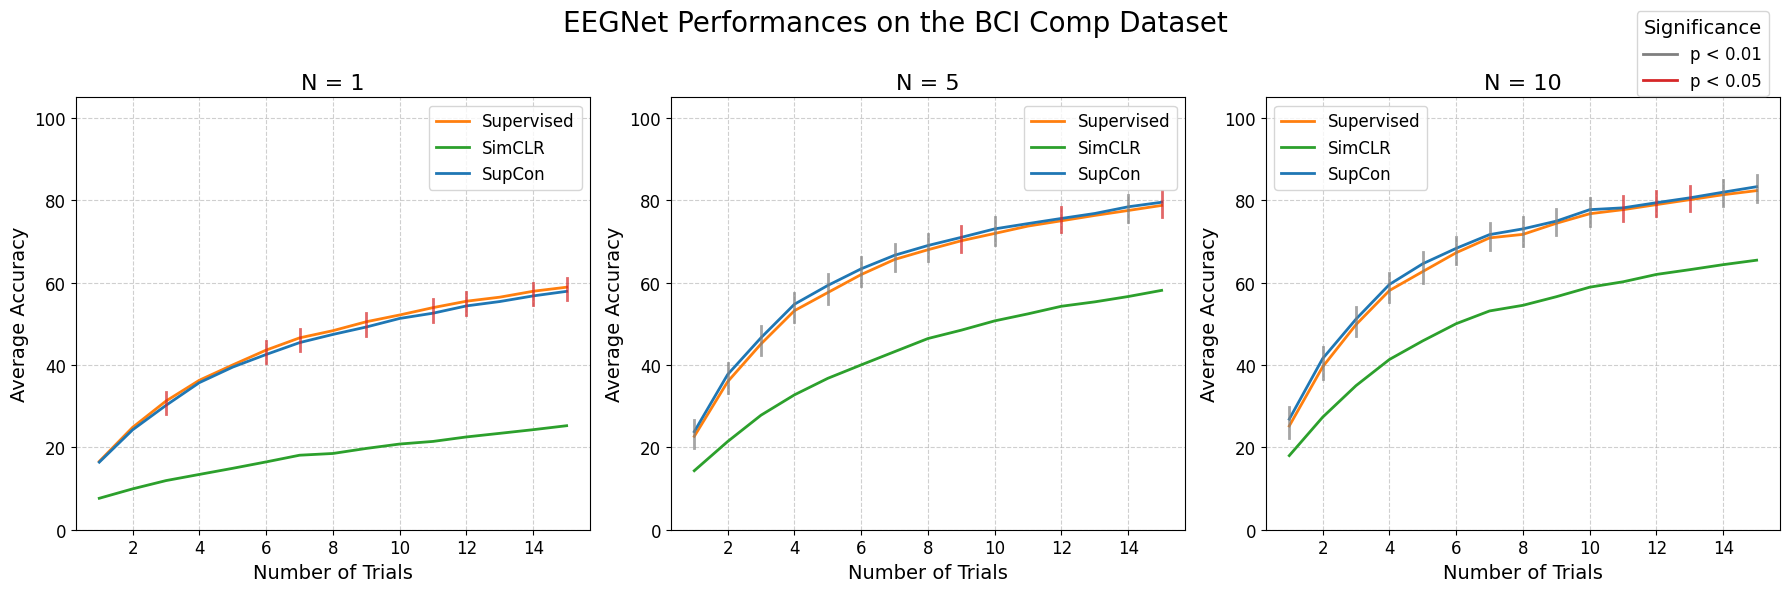

In [25]:
file_paths = [
    os.path.join(scripts_folder, 'IntraEvaluation/Supervised_results/EEGNet_1CLS_evaluation_results.txt'),
    os.path.join(scripts_folder, 'IntraEvaluation/SimCLR_results/EEGNet_1CLS_evaluation_results.txt'),
    os.path.join(scripts_folder, 'IntraEvaluation/SupCon_results/EEGNet_1CLS_evaluation_results.txt')
]
eegnet_fig = statistical_analysis_Intra(file_paths, 'EEGNet')

Analysing data from 1 Retraining Chars

N Trials -> 1

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 627.1366160681224, p_value = 6.591953286062264e-137)
Post-hoc Wilcoxon tests for trial 1:
Wilcoxon test between Supervised and SimCLR: p-value = 7.23059626438688e-102
Wilcoxon test between SimCLR and SupCon: p-value = 4.105851385802694e-85
Wilcoxon test between Supervised and SupCon: p-value = 1.957408883689985e-17

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 730.9527645551086, p_value = 1.8863570994092603e-159)
Post-hoc Wilcoxon tests for trial 2:
Wilcoxon test between Supervised and SimCLR: p-value = 4.406922552947462e-108
Wilcoxon test between SimCLR and SupCon: p-value = 6.340642601640355e-93
Wilcoxon test between Supervised and SupCon: p-value = 3.0726388426095543e-28

N Trials -> 3

Is data Normally Distributed? - False
Is Variance Homogeneous? - F

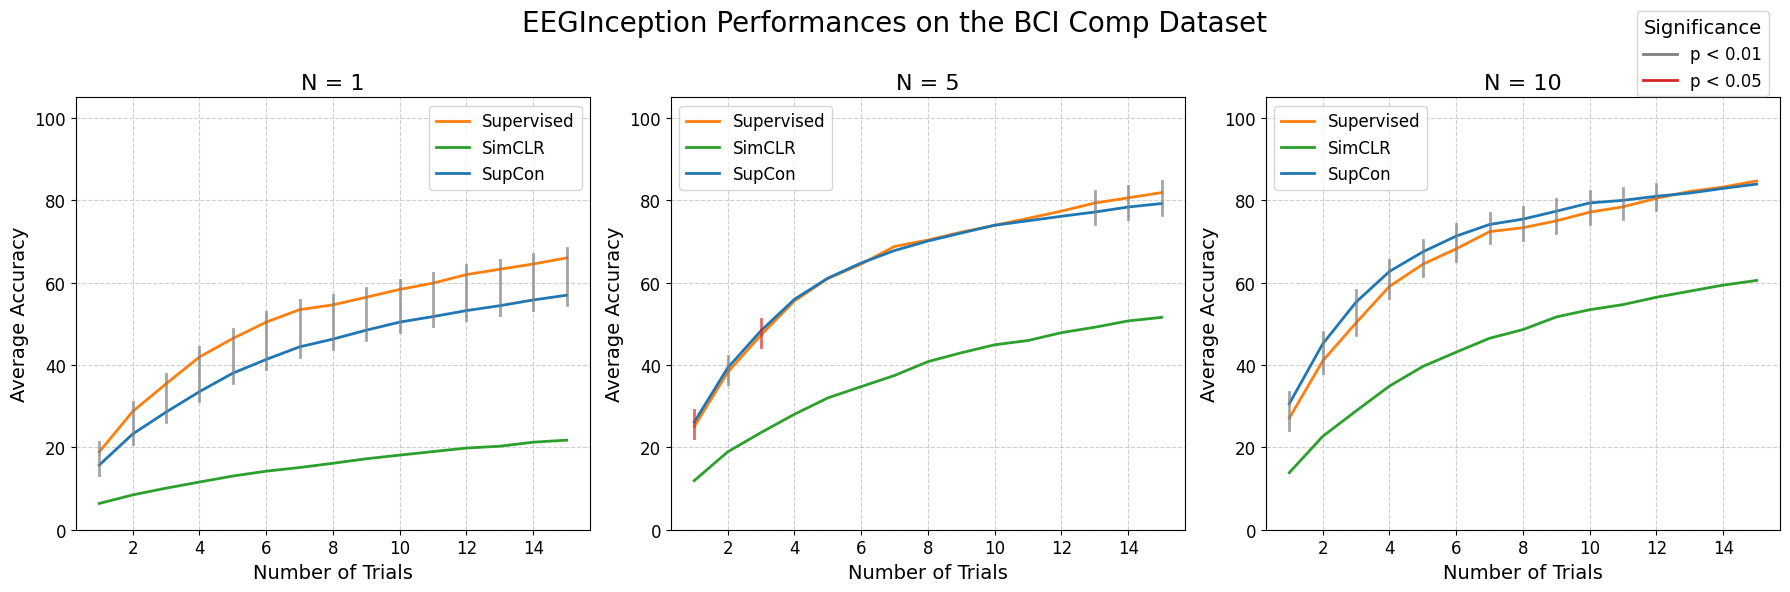

In [26]:
file_paths = [
    os.path.join(scripts_folder, 'IntraEvaluation/Supervised_results/EEGInception_1CLS_evaluation_results.txt'),
    os.path.join(scripts_folder, 'IntraEvaluation/SimCLR_results/EEGInception_1CLS_evaluation_results.txt'),
    os.path.join(scripts_folder, 'IntraEvaluation/SupCon_results/EEGInception_1CLS_evaluation_results.txt')
]
eeginception_fig = statistical_analysis_Intra(file_paths, 'EEGInception')

Analysing data from 1 Retraining Chars

N Trials -> 1

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 594.3734533183361, p_value = 8.579155053674803e-130)
Post-hoc Wilcoxon tests for trial 1:
Wilcoxon test between Supervised and SimCLR: p-value = 6.2922955383844535e-93
Wilcoxon test between SimCLR and SupCon: p-value = 5.083304875750816e-88
Wilcoxon test between Supervised and SupCon: p-value = 0.6182933558723234

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 650.2748710390567, p_value = 6.231690757496352e-142)
Post-hoc Wilcoxon tests for trial 2:
Wilcoxon test between Supervised and SimCLR: p-value = 1.6469705264547704e-100
Wilcoxon test between SimCLR and SupCon: p-value = 9.062970334019967e-96
Wilcoxon test between Supervised and SupCon: p-value = 0.005461456335599122

N Trials -> 3

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

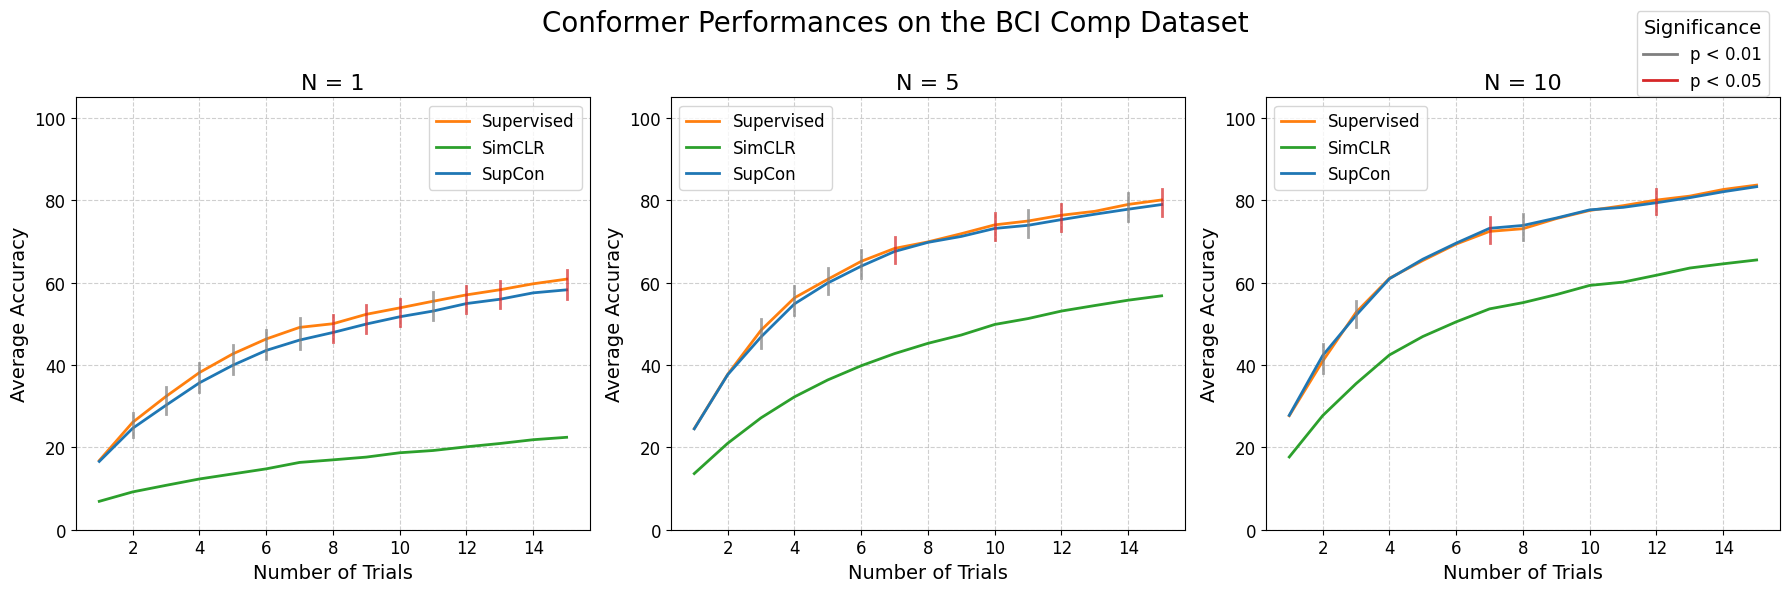

In [27]:
file_paths = [
    os.path.join(scripts_folder, 'IntraEvaluation/Supervised_results/Conformer_1CLS_evaluation_results.txt'),
    os.path.join(scripts_folder, 'IntraEvaluation/SimCLR_results/Conformer_1CLS_evaluation_results.txt'),
    os.path.join(scripts_folder, 'IntraEvaluation/SupCon_results/Conformer_1CLS_evaluation_results.txt')
]
conformer_fig = statistical_analysis_Intra(file_paths, 'Conformer')

## BCI EVALUATION

In [28]:
# Usage
filename = os.path.join(scripts_folder, 'CrossEvaluation/BCI Results/SupCon_results/Conformer_1CLS_50Folfd_evaluation_results.txt') 
block_averages = parse_file(filename)

for i, mean in enumerate(block_averages, 1):
    print(f"Block {i} Mean: {list(mean)}")

overall_indices = [0,1]

# Compute statistics
ft_values = [1, 5, 10, 25, 40, 85]
for i in range(len(ft_values)):
    print(f'Performance for {ft_values[i]} chars')
    overall_mean, overall_std = compute_group_statistics(block_averages[i*2:(i+1)*2], overall_indices)

    # Print results
    print("Performance Analysis:")
    print(f"Overall: {format_mean_std(overall_mean, overall_std)}")

print()

selected_indices = [0, 4, 9, 14]
for i in range(len(ft_values)):
    print()
    print(f'Performance for {ft_values[i]} chars')
    overall_mean, overall_std = compute_group_statistics(block_averages[i*2:(i+1)*2], overall_indices)

    # Print results
    print("Performance Analysis:")
    print(f"Overall: {format_mean_std(overall_mean, overall_std, selected_indices)}")

Block 1 Mean: [2.88, 3.76, 3.64, 4.34, 4.56, 5.6, 6.0, 6.24, 6.3, 6.26, 7.02, 7.1, 7.54, 7.66, 8.62]
Block 2 Mean: [3.24, 3.74, 3.68, 3.96, 4.0, 4.26, 4.76, 5.48, 4.72, 5.24, 5.08, 5.12, 5.24, 5.58, 5.84]
Block 3 Mean: [4.3, 6.78, 7.4, 8.86, 11.72, 14.28, 15.54, 17.1, 18.34, 19.62, 20.66, 23.24, 25.6, 27.64, 28.76]
Block 4 Mean: [6.58, 9.1, 10.04, 10.3, 11.9, 12.5, 14.3, 15.78, 17.34, 18.7, 18.98, 20.38, 21.48, 22.42, 23.92]
Block 5 Mean: [5.08, 9.48, 9.58, 11.9, 16.26, 20.68, 23.2, 25.18, 26.74, 29.68, 30.88, 35.64, 39.6, 42.18, 43.32]
Block 6 Mean: [9.24, 13.58, 15.92, 16.48, 18.26, 19.96, 23.86, 26.86, 27.74, 29.28, 31.78, 34.1, 35.74, 38.18, 40.54]
Block 7 Mean: [6.44, 12.08, 13.42, 16.82, 22.38, 28.32, 31.96, 35.2, 37.64, 41.56, 44.24, 49.6, 54.0, 56.12, 57.1]
Block 8 Mean: [13.8, 19.06, 24.28, 24.8, 28.36, 31.98, 37.3, 41.48, 41.4, 42.82, 46.26, 49.32, 51.04, 54.62, 56.78]
Block 9 Mean: [6.36, 12.58, 13.62, 16.58, 23.58, 30.8, 33.82, 37.46, 40.46, 44.44, 46.74, 52.48, 57.48, 58.8

In [29]:
file_paths = [
    os.path.join(scripts_folder, 'CrossEvaluation/BCI Results/Supervised_results/EEGNet_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/BCI Results/SimCLR_results/EEGNet_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/BCI Results/SupCon_results/EEGNet_1CLS_50Folfd_evaluation_results.txt')
]
get_differences(file_paths, 'EEGNet', retraining_chars=[1, 5, 10, 25, 40, 85], dataset='BCI')


ALL SUBJECTS

Analysing data from 1 Retraining Chars

N Trials -> 1

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 26.17391304347818, p_value = 2.0720822845413334e-06)
Post-hoc Wilcoxon tests for trial 1:
Wilcoxon test between SimCLR and Supervised: p-value = 3.018359730471054e-08: diff -> 6.22 - 3.53 = 2.69
Wilcoxon test between SupCon and SimCLR: p-value = 8.007923650807664e-05: diff -> 4.24 - 6.22 = -1.98
Wilcoxon test between SupCon and Supervised: p-value = 0.01648990718167938: diff -> 4.24 - 3.53 = 0.71

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 35.36927223719683, p_value = 2.0876616781488336e-08)
Post-hoc Wilcoxon tests for trial 2:
Wilcoxon test between SimCLR and Supervised: p-value = 1.4053909989413864e-09: diff -> 8.63 - 4.19 = 4.44
Wilcoxon test between SupCon and SimCLR: p-value = 0.00032271176992745837: diff -> 5.83 - 8.63 = -2.80
Wilco

Analysing data from 1 Retraining Chars

N Trials -> 1

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 26.17391304347818, p_value = 2.0720822845413334e-06)
Post-hoc Wilcoxon tests for trial 1:
Wilcoxon test between Supervised and SimCLR: p-value = 3.018359730471054e-08
Wilcoxon test between SimCLR and SupCon: p-value = 8.007923650807664e-05
Wilcoxon test between Supervised and SupCon: p-value = 0.01648990718167938

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 35.36927223719683, p_value = 2.0876616781488336e-08)
Post-hoc Wilcoxon tests for trial 2:
Wilcoxon test between Supervised and SimCLR: p-value = 1.4053909989413864e-09
Wilcoxon test between SimCLR and SupCon: p-value = 0.00032271176992745837
Wilcoxon test between Supervised and SupCon: p-value = 0.00024058813879265965

N Trials -> 3

Is data Normally Distributed? - False
Is Variance Homogeneous? - Fal

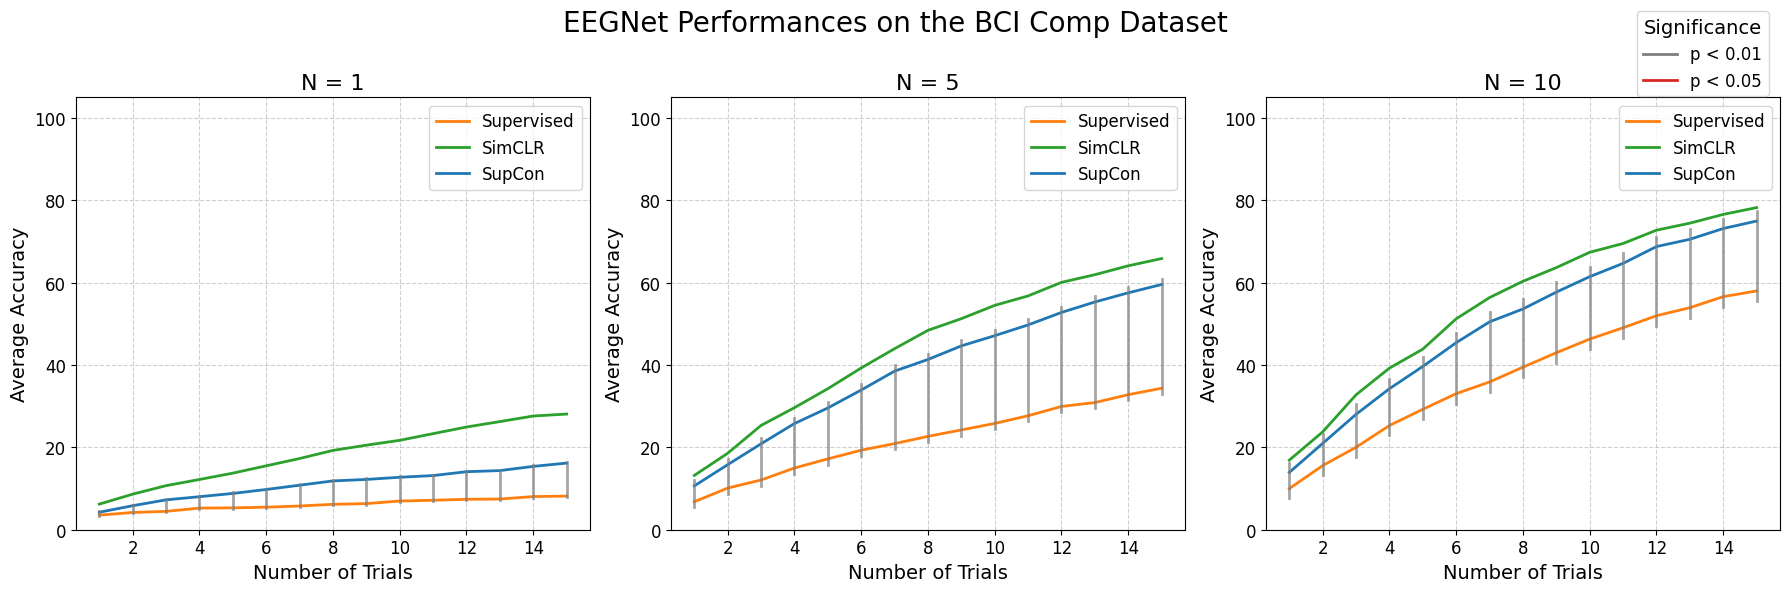

In [54]:
file_paths = [
    os.path.join(scripts_folder, 'CrossEvaluation/BCI Results/Supervised_results/EEGNet_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/BCI Results/SimCLR_results/EEGNet_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/BCI Results/SupCon_results/EEGNet_1CLS_50Folfd_evaluation_results.txt')
]
statistical_analysis_Intra(file_paths, 'EEGNet', retraining_chars=[1, 5, 10], dataset='BCI')

In [31]:
file_paths = [
    os.path.join(scripts_folder, 'CrossEvaluation/BCI Results/Supervised_results/EEGInception_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/BCI Results/SimCLR_results/EEGInception_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/BCI Results/SupCon_results/EEGInception_1CLS_50Folfd_evaluation_results.txt')
]
get_differences(file_paths, 'EEGInception', retraining_chars=[1, 5, 10, 25, 40, 85], dataset='BCI')


ALL SUBJECTS

Analysing data from 1 Retraining Chars

N Trials -> 1

Is data Normally Distributed? - False
Is Variance Homogeneous? - True

Friedman Test results: (F-stat = 9.0416666666667, p_value = 0.010879953262024768)
Post-hoc Wilcoxon tests for trial 1:
Wilcoxon test between SupCon and Supervised: p-value = 0.0034131288870483415: diff -> 2.65 - 3.54 = -0.89
Wilcoxon test between SupCon and SimCLR: p-value = 0.05095397888935817: diff -> 2.65 - 3.18 = -0.53
Wilcoxon test between SimCLR and Supervised: p-value = 0.16304072606512898: diff -> 3.18 - 3.54 = -0.36

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - True

Friedman Test results: (F-stat = 20.365650969529206, p_value = 3.781421435962512e-05)
Post-hoc Wilcoxon tests for trial 2:
Wilcoxon test between SupCon and Supervised: p-value = 0.00018626724380297097: diff -> 2.94 - 4.09 = -1.15
Wilcoxon test between SimCLR and Supervised: p-value = 0.0006853142402131185: diff -> 3.01 - 4.09 = -1.08
Wilcoxo

Analysing data from 1 Retraining Chars

N Trials -> 1

Is data Normally Distributed? - False
Is Variance Homogeneous? - True

Friedman Test results: (F-stat = 3.1206896551723196, p_value = 0.2100636229783582)

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - True

Friedman Test results: (F-stat = 1.1020408163264563, p_value = 0.5763613863516001)

N Trials -> 3

Is data Normally Distributed? - False
Is Variance Homogeneous? - True

Friedman Test results: (F-stat = 2.930635838150384, p_value = 0.23100453905256466)

N Trials -> 4

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 1.2329545454545867, p_value = 0.5398428108987241)

N Trials -> 5

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 1.6121883656508889, p_value = 0.4465989981659574)

N Trials -> 6

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results

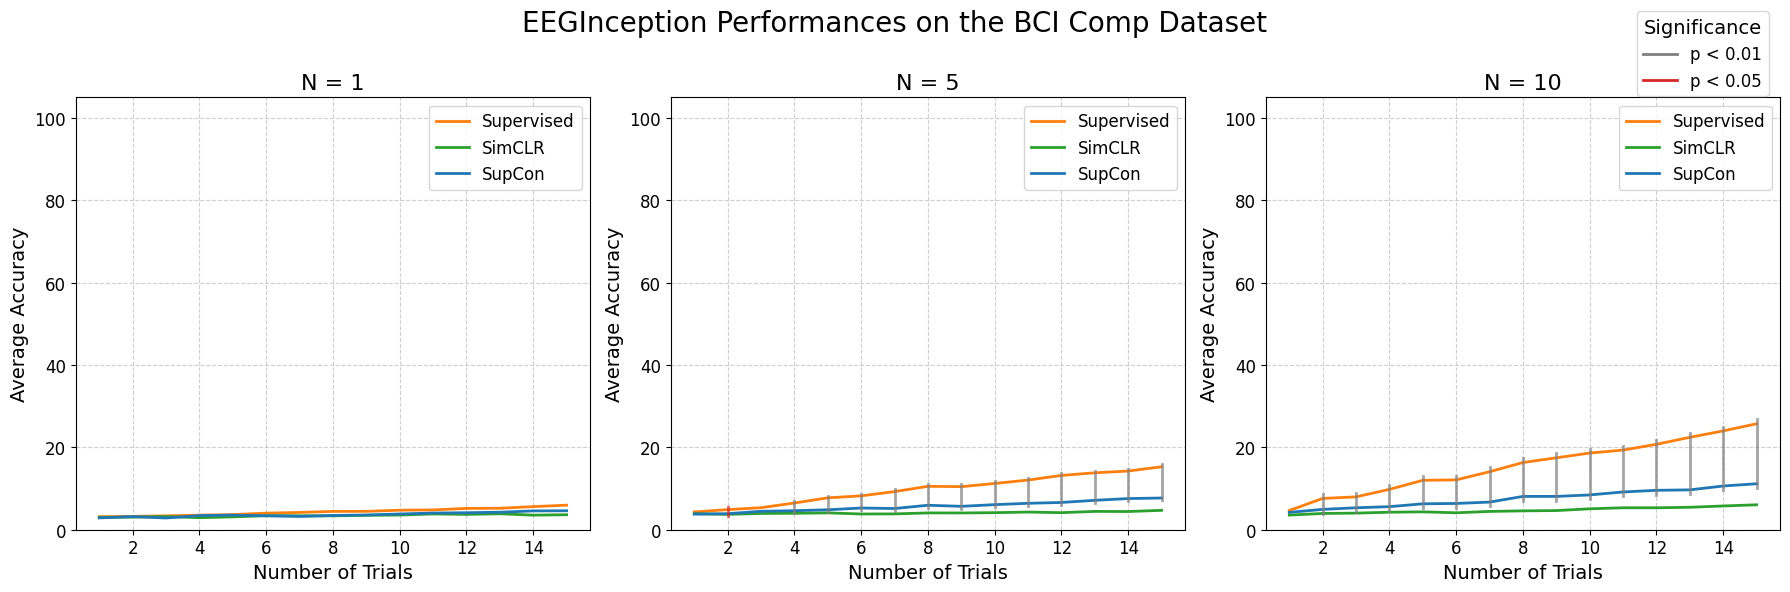

In [51]:
file_paths = [
    os.path.join(scripts_folder, 'CrossEvaluation/BCI Results/Supervised_results/EEGInception_1CLS_INTRA_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/BCI Results/SimCLR_results/EEGInception_1CLS_INTRA_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/BCI Results/SupCon_results/EEGInception_1CLS_INTRA_50Folfd_evaluation_results.txt')
]
statistical_analysis_Intra(file_paths, 'EEGInception', retraining_chars=[1, 5, 10], dataset='BCI')

In [33]:
file_paths = [
    os.path.join(scripts_folder, 'CrossEvaluation/BCI Results/Supervised_results/Conformer_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/BCI Results/SimCLR_results/Conformer_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/BCI Results/SupCon_results/Conformer_1CLS_50Folfd_evaluation_results.txt')
]
get_differences(file_paths, 'Conformer', retraining_chars=[1, 5, 10, 25, 40, 85], dataset='BCI')


ALL SUBJECTS

Analysing data from 1 Retraining Chars

N Trials -> 1

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 16.26183844011145, p_value = 0.00029429755221970215)
Post-hoc Wilcoxon tests for trial 1:
Wilcoxon test between SimCLR and Supervised: p-value = 8.657533458729078e-06: diff -> 4.30 - 2.93 = 1.37
Wilcoxon test between SupCon and SimCLR: p-value = 0.00013937955307280085: diff -> 3.06 - 4.30 = -1.24
Wilcoxon test between SupCon and Supervised: p-value = 0.5820603720803204: diff -> 3.06 - 2.93 = 0.13

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 6.296495956873227, p_value = 0.04292727052478093)
Post-hoc Wilcoxon tests for trial 2:
Wilcoxon test between SimCLR and Supervised: p-value = 0.00043765178181088264: diff -> 4.97 - 3.34 = 1.63
Wilcoxon test between SupCon and SimCLR: p-value = 0.01985043251730452: diff -> 3.75 - 4.97 = -1.22
Wilcoxon te

Analysing data from 1 Retraining Chars

N Trials -> 1

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 4.0171428571429715, p_value = 0.13418022384944825)

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 4.105555555555485, p_value = 0.1283778028362814)

N Trials -> 3

Is data Normally Distributed? - False
Is Variance Homogeneous? - True

Friedman Test results: (F-stat = 5.839572192513407, p_value = 0.05394522515191016)

N Trials -> 4

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 7.553719008264483, p_value = 0.022894478657957285)
Post-hoc Wilcoxon tests for trial 4:
Wilcoxon test between Supervised and SimCLR: p-value = 0.0021376256874417665
Wilcoxon test between SimCLR and SupCon: p-value = 0.02213207239568404
Wilcoxon test between Supervised and SupCon: p-value = 0.09768986286476077

N Trials -> 5

I

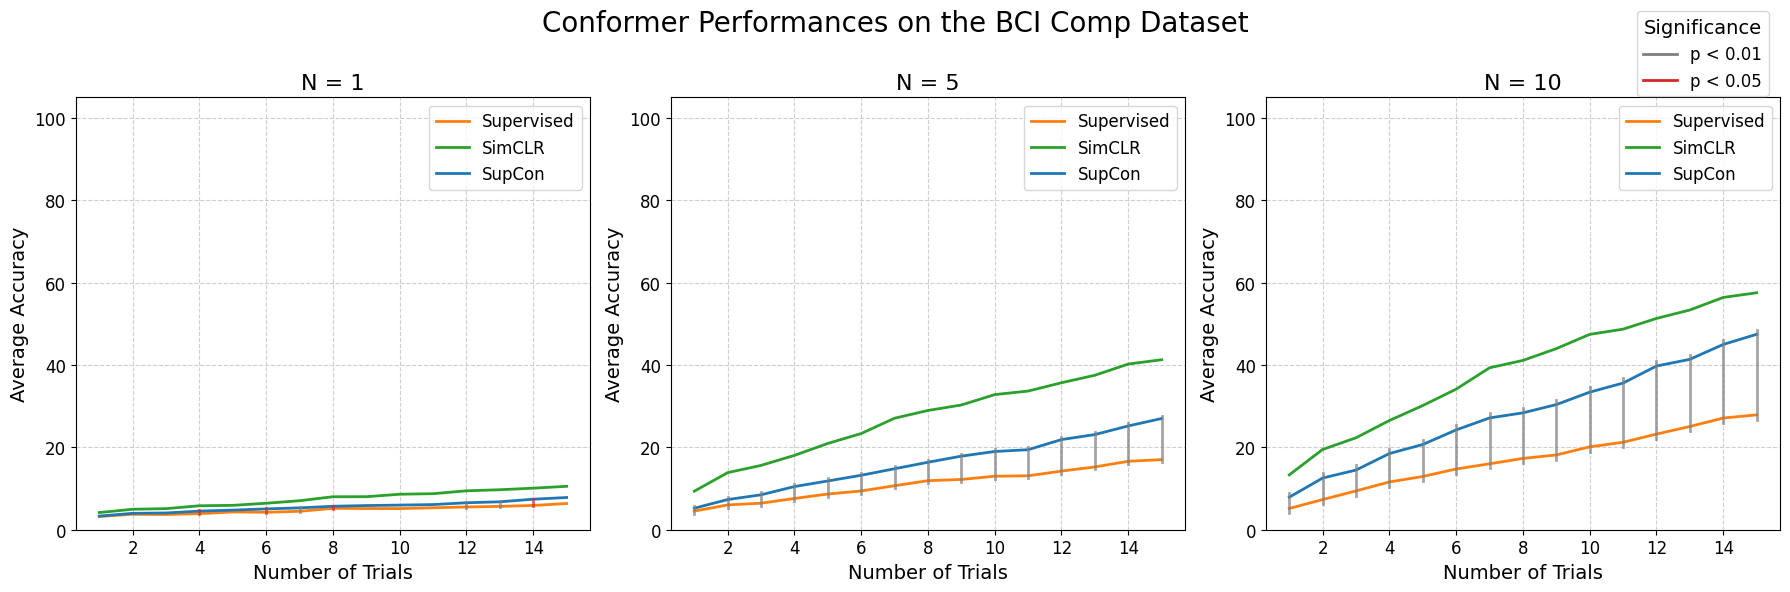

In [50]:
#! Change files 
file_paths = [
    os.path.join(scripts_folder, 'CrossEvaluation/BCI Results/Supervised_results/Conformer_1CLS_INTRA_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/BCI Results/SimCLR_results/Conformer_1CLS_INTRA_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/BCI Results/SupCon_results/Conformer_1CLS_INTRA_50Folfd_evaluation_results.txt')
]
statistical_analysis_Intra(file_paths, 'Conformer', retraining_chars=[1, 5, 10], dataset='BCI')

## ALS EVALUATION

In [35]:
def get_differences_als(files, model):

    strategies = ['Supervised', 'SimCLR', 'SupCon']
    
    blocks = []
    means = []
    print(f'\n{model}')
    for idx, file_path in enumerate(files):
        print(f'\n{strategies[idx]}')
        block = read_als_file(file_path)
        blocks.append(block)
        mean = np.mean(block, axis=0)
        means.append(mean)
        std = np.std(block, axis=0)
        
        print( ' & '.join([f'{mean[i]:.2f} ± {std[i]:.2f}' for i in [0, 4, 9]]))
        
    trial_results = {trial: [np.array(strategy)[:, trial] for strategy in blocks] for trial in range(10)}
    # print(trial_results)
    friedman_results = []
    differences = {'SimCLR': [], 'SupCon': []}
    
            
    for trial, data in trial_results.items():
        print(f'\nN Trials -> {trial+1}')
        trial_data = [d for d in data]
                
        # Check normality and homogeneity of variance.
        normality = all(shapiro(d).pvalue > 0.05 for d in trial_data)
        homogeneity = levene(*trial_data).pvalue > 0.05
        print(f'\nIs data Normally Distributed? - {normality}')
        print(f'Is Variance Homogeneous? - {homogeneity}')
                
        f_stat, p_value = friedmanchisquare(*trial_data)
        print(f'\nFriedman Test results: (F-stat = {f_stat}, p_value = {p_value})')
        friedman_results.append((trial + 1, f_stat, p_value, "Friedman Test"))
                
        # Wilcoxon post-hoc test
        if p_value < 0.05:
            p_values = []
            pairs = list(itertools.combinations(range(len(trial_data)), 2))  
            adjusted_p_values = []
                    
            for (i, j) in pairs:
                stat, p_value_wilcoxon = wilcoxon(trial_data[i], trial_data[j])
                p_values.append((i, j, p_value_wilcoxon))
                        
            # Apply Benjamini-Hochberg correction
            sorted_p_values = sorted(p_values, key=lambda x: x[2])  # Sort by p-value
            m = len(sorted_p_values)  # Total number of tests
                    
                        
            for k, (i, j, p) in enumerate(sorted_p_values):
                adjusted_p = p * m / (k + 1)
                adjusted_p = min(adjusted_p, 1)  # Ensure adjusted p-value does not exceed 1
                adjusted_p_values.append((i, j, adjusted_p))
                            
                    
            print(f"Post-hoc Wilcoxon tests for trial {trial + 1}:")
                    
            for (i, j, adj_p_value) in adjusted_p_values:
                diff = means[j][trial] - means[i][trial]
                print(f"Wilcoxon test between {strategies[j]} and {strategies[i]}: p-value = {adj_p_value}: diff -> {means[j][trial]:.2f} - {means[i][trial]:.2f} = {diff:.2f}")
                if adj_p_value < 0.05 and strategies[i] == 'Supervised':
                    differences[strategies[j]].append(diff)
                            
    print(f'\nDifferences: {differences}')
    print(f'\nAverage Difference: ({np.mean(differences["SimCLR"]):.2f}, {np.mean(differences["SupCon"]):.2f})\n')

In [36]:
files =   [
    os.path.join(scripts_folder, 'CrossEvaluation/ALS Results/Supervised_results/EEGNet_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/ALS Results/SimCLR_results/EEGNet_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/ALS Results/SupCon_results/EEGNet_1CLS_50Folfd_evaluation_results.txt')
    ]
get_differences_als(files, 'EEGNet')


EEGNet

Supervised
8.28 ± 5.40 & 29.12 ± 19.18 & 41.52 ± 22.35

SimCLR
17.04 ± 9.64 & 49.26 ± 18.48 & 66.23 ± 16.40

SupCon
16.80 ± 7.93 & 44.83 ± 21.49 & 59.95 ± 20.80

N Trials -> 1

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 354.9178470254959, p_value = 8.522534224363585e-78)
Post-hoc Wilcoxon tests for trial 1:
Wilcoxon test between SupCon and Supervised: p-value = 5.095105170298128e-53: diff -> 16.80 - 8.28 = 8.52
Wilcoxon test between SimCLR and Supervised: p-value = 2.1792289042013823e-49: diff -> 17.04 - 8.28 = 8.76
Wilcoxon test between SupCon and SimCLR: p-value = 0.23082677119790762: diff -> 16.80 - 17.04 = -0.24

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 253.62301587301582, p_value = 8.44232100300851e-56)
Post-hoc Wilcoxon tests for trial 2:
Wilcoxon test between SupCon and Supervised: p-value = 3.9883833009807087e-38: diff -> 25.86 - 

In [37]:
files =   [
    os.path.join(scripts_folder, 'CrossEvaluation/ALS Results/Supervised_results/EEGInception_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/ALS Results/SimCLR_results/EEGInception_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/ALS Results/SupCon_results/EEGInception_1CLS_50Folfd_evaluation_results.txt')
    ]
get_differences_als(files, 'EEGInception')


EEGInception

Supervised
10.51 ± 6.60 & 15.75 ± 9.88 & 25.71 ± 17.23

SimCLR
4.15 ± 4.29 & 14.17 ± 12.13 & 16.01 ± 16.01

SupCon
5.22 ± 4.60 & 15.73 ± 11.56 & 23.77 ± 15.40

N Trials -> 1

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 182.40504451038626, p_value = 2.4617721199642416e-40)
Post-hoc Wilcoxon tests for trial 1:
Wilcoxon test between SimCLR and Supervised: p-value = 1.2608706101888595e-30: diff -> 4.15 - 10.51 = -6.36
Wilcoxon test between SupCon and Supervised: p-value = 1.7090522348154152e-24: diff -> 5.22 - 10.51 = -5.29
Wilcoxon test between SupCon and SimCLR: p-value = 1.3299070483250181e-05: diff -> 5.22 - 4.15 = 1.07

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 125.92090395480284, p_value = 4.5354786621509315e-28)
Post-hoc Wilcoxon tests for trial 2:
Wilcoxon test between SimCLR and Supervised: p-value = 1.9586780512684174e-22: diff 

In [38]:
files =   [
    os.path.join(scripts_folder, 'CrossEvaluation/ALS Results/Supervised_results/Conformer_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/ALS Results/SimCLR_results/Conformer_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/ALS Results/SupCon_results/Conformer_1CLS_50Folfd_evaluation_results.txt')
    ]
get_differences_als(files, 'Conformer')


Conformer

Supervised
4.61 ± 4.03 & 11.96 ± 9.37 & 16.15 ± 12.38

SimCLR
6.04 ± 4.89 & 21.90 ± 12.21 & 34.35 ± 18.45

SupCon
5.36 ± 4.60 & 13.68 ± 9.51 & 17.24 ± 11.20

N Trials -> 1

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 27.903816793893753, p_value = 8.724954507296358e-07)
Post-hoc Wilcoxon tests for trial 1:
Wilcoxon test between SimCLR and Supervised: p-value = 5.85245379676886e-06: diff -> 6.04 - 4.61 = 1.43
Wilcoxon test between SupCon and SimCLR: p-value = 0.014054847657371144: diff -> 5.36 - 6.04 = -0.68
Wilcoxon test between SupCon and Supervised: p-value = 0.010746446460620668: diff -> 5.36 - 4.61 = 0.75

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 165.40261627906995, p_value = 1.2113739463199407e-36)
Post-hoc Wilcoxon tests for trial 2:
Wilcoxon test between SimCLR and Supervised: p-value = 3.3293207985315463e-37: diff -> 12.23 - 6.29

In [39]:
def plot_als_results(files_paths:list, model_names:list):
    
    strategies = ['Supervised', 'SimCLR', 'SupCon']
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    pallete = sns.color_palette(n_colors=8)
    blue, orange, green, red, gray = pallete[0], pallete[1], pallete[2], pallete[3], pallete[7]
    colors = [orange, green, blue]
    
    def configure_axis(ax, model):
        ax.set_title(model, fontsize=18)
        ax.set_xlabel("Number of Trials", fontsize=14)
        ax.set_ylabel("Average Accuracy", fontsize=14)
        ax.set_ylim([0, 105])
        ax.set_xticks(range(1, 11))
        ax.tick_params(axis='both', labelsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)
    
    for ax_numbr, model in enumerate(model_names):
        blocks = {x: None for x in strategies}
        means = []
        for file_path, strategy, color in zip(files_paths[ax_numbr], strategies, colors):
            block = read_als_file(file_path)
            # print(len(block))
            blocks[strategy] = block
            
            mean = np.mean(block, axis=0)
            means.append(mean)
            
            axes[ax_numbr].plot(range(1,11), mean, label=strategy, color=color, linewidth=2)
         
        configure_axis(axes[ax_numbr], model)
        axes[ax_numbr].legend(fontsize=12)   
        
        trial_results = {trial: [np.array(data)[:, trial] for data in blocks.values()] for trial in range(10)}
        # print(trial_results)
        p_values = []
        friedman_results = []
        significant_trials = []

        # Perform Friedman's test across all trials
        for trial, data in trial_results.items():
            stat, p_value = friedmanchisquare(*data)
            friedman_results.append((trial + 1, stat, p_value))
            p_values.append(p_value)

        # Wilcoxon post-hoc test
            if p_value < 0.05:
                p_values_wilcoxon = []
                pairs = list(itertools.combinations(range(len(data)), 2))  
                # print(pairs)
                adjusted_p_values = []
                
                for (i, j) in pairs:
                    stat, p_value_wilcoxon = wilcoxon(data[i], data[j])
                    p_values_wilcoxon.append((i, j, p_value_wilcoxon))
                        
                # Apply Benjamini-Hochberg correction
                sorted_p_values = sorted(p_values_wilcoxon, key=lambda x: x[2])  # Sort by p-value
                m = len(sorted_p_values)  # Total number of tests
                    
                for k, (i, j, p) in enumerate(sorted_p_values):
                    adjusted_p = p * m / (k + 1)
                    adjusted_p = min(adjusted_p, 1)  # Ensure adjusted p-value does not exceed 1
                    adjusted_p_values.append((i, j, adjusted_p))
    
                    
                print(f"Post-hoc Wilcoxon tests for trial {trial + 1}:")
                for (i, j, adj_p_value) in adjusted_p_values:
                    print(f"Wilcoxon test between {strategies[i]} and {strategies[j]}: p-value = {adj_p_value}")
                    significant_trials.append((trial + 1, i, j, adj_p_value)) if adj_p_value < 0.05 else None
                        
        for trial, i, j, p_value in significant_trials:
            if p_value < 0.05 and i == 0 and j == 2:  # For significance at p < 0.05
                # Get the values for strategy 0 and 2 at this trial
                y_val_i = means[0][trial - 1]  # Supervised (Strategy 0)
                y_val_j = means[2][trial - 1]  # SupCon (Strategy 2)
                
                # Calculate a small buffer to extend the line beyond the two points
                y_buffer = (max(means[0]) - min(means[0])) * 0.05  # Extend 5% of the range
                
                # Set the line color based on the p-value
                line_color = gray if p_value < 0.01 else red
                
                # Plot a vertical line from y_val_0 to y_val_2, with a buffer above and below
                axes[ax_numbr].plot([trial, trial], 
                                    [min(y_val_i, y_val_j) - y_buffer, max(y_val_i, y_val_j) + y_buffer], 
                                    color=line_color, linestyle='-', alpha=0.7, linewidth=2)       
                
         
    # Create custom legend handles for the vertical lines
    red_line = Line2D([0], [0], color=red, lw=2, linestyle='-', label='p < 0.05')
    black_line = Line2D([0], [0], color=gray, lw=2, linestyle='-', label='p < 0.01')
        
    # Add custom legend to the lower right corner
    fig.legend(handles=[black_line, red_line], loc='upper right', fontsize=12, title="Significance", title_fontsize=14, bbox_to_anchor=(0.99, 0.98))
    
    plt.suptitle(f'ALS Dataset \nAverage Accuracy across Number of Trials for each Model', fontsize=18)    
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

Post-hoc Wilcoxon tests for trial 1:
Wilcoxon test between Supervised and SupCon: p-value = 5.095105170298128e-53
Wilcoxon test between Supervised and SimCLR: p-value = 2.1792289042013823e-49
Wilcoxon test between SimCLR and SupCon: p-value = 0.23082677119790762
Post-hoc Wilcoxon tests for trial 2:
Wilcoxon test between Supervised and SupCon: p-value = 3.9883833009807087e-38
Wilcoxon test between Supervised and SimCLR: p-value = 5.314536962081886e-34
Wilcoxon test between SimCLR and SupCon: p-value = 0.538731953399577
Post-hoc Wilcoxon tests for trial 3:
Wilcoxon test between Supervised and SimCLR: p-value = 3.411644131610091e-45
Wilcoxon test between Supervised and SupCon: p-value = 3.897750515227371e-35
Wilcoxon test between SimCLR and SupCon: p-value = 6.053527605547961e-26
Post-hoc Wilcoxon tests for trial 4:
Wilcoxon test between Supervised and SimCLR: p-value = 1.1065570753100676e-49
Wilcoxon test between Supervised and SupCon: p-value = 3.7977112746411e-38
Wilcoxon test between 

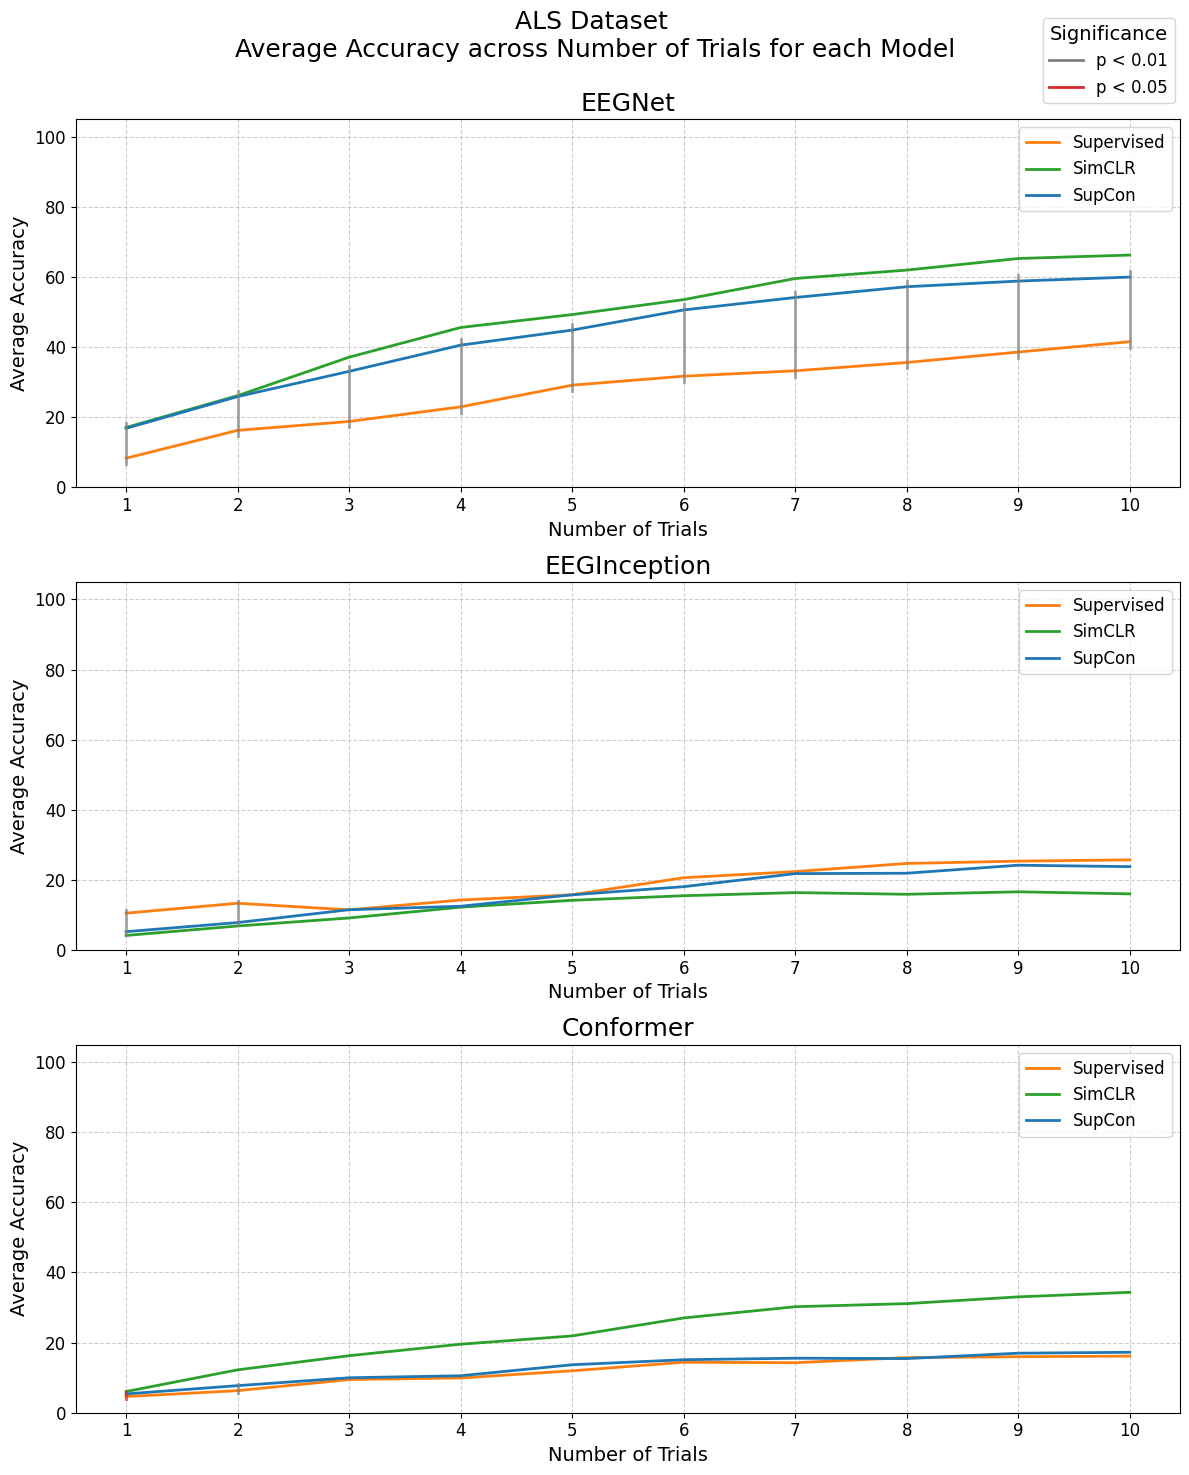

In [40]:
files = [
    [
    os.path.join(scripts_folder, 'CrossEvaluation/ALS Results/Supervised_results/EEGNet_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/ALS Results/SimCLR_results/EEGNet_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/ALS Results/SupCon_results/EEGNet_1CLS_50Folfd_evaluation_results.txt')
    ],
    [
    os.path.join(scripts_folder, 'CrossEvaluation/ALS Results/Supervised_results/EEGInception_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/ALS Results/SimCLR_results/EEGInception_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/ALS Results/SupCon_results/EEGInception_1CLS_50Folfd_evaluation_results.txt')
    ],
    [
    os.path.join(scripts_folder, 'CrossEvaluation/ALS Results/Supervised_results/Conformer_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/ALS Results/SimCLR_results/Conformer_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/ALS Results/SupCon_results/Conformer_1CLS_50Folfd_evaluation_results.txt')
    ]
]

model_names = ['EEGNet', 'EEGInception', 'Conformer']

plot_als_results(files, model_names)       

## Intra vs. Cross

In [41]:
def plot_intra_cross(file_paths:list, model, retraining_chars = [1, 5, 10, 25, 40, 85], dataset='BCI'):
    strategies = ['SimCLR Cross', 'SimCLR Intra']
    
    # Create a larger figure for publication-quality plots
    if dataset=='ALS':
        fig, axes = plt.subplots(1, len(retraining_chars), figsize=(18, 6)) 
        n_trials = range(10)
        x_values = range(1,11)
        x_label = x_values
    else:
        fig, axes = plt.subplots(2, len(retraining_chars) // 2, figsize=(18, 12)) 
        axes = axes.flatten()
        n_trials = range(15)
        x_values = range(1,16)
        x_label = [2, 4, 6, 8, 10, 12, 14]
    
    retraining_char_dict = {i: [] for i in retraining_chars}
    # print(retraining_char_dict)
    
    for file_path in file_paths:
        if dataset=='BCI':
            blocks = read_and_separate_blocks(file_path, dataset)
            for n_char in retraining_chars:
                retraining_char_dict[n_char].append(blocks[n_char])
        else:
            blocks = read_als_file(file_path)
            retraining_char_dict[1].append(blocks)

    for retraining_idx, (retraining_char, reatraining_data) in enumerate(retraining_char_dict.items()):
        
        means = [np.mean(d, axis=0) for d in reatraining_data]
        std_deviations = [np.std(d, axis=0) for d in reatraining_data]
        
        print(f'Analysing data from {retraining_char} Retraining Chars')
        trial_results = {trial: [np.array(model)[:, trial] for model in reatraining_data] for trial in n_trials}
        
        stat_results = []
        
        # Loop through each trial to perform statistical tests
        for trial, data in trial_results.items():
            print(f'\nN Trials -> {trial+1}')
            trial_data = [d for d in data]

            # Check normality and homogeneity of variance.
            normality = all(shapiro(d).pvalue > 0.05 for d in trial_data)
            homogeneity = levene(*trial_data).pvalue > 0.05
            print(f'\nIs data Normally Distributed? - {normality}')
            print(f'Is Variance Homogeneous? - {homogeneity}')

            # Perform the Mann-Whitney U Test
            stat, p_value = mannwhitneyu(*trial_data, alternative='two-sided')
            print(f'\nMann Whitney U Test results: (F-stat = {stat}, p_value = {p_value})')
            stat_results.append((trial + 1, stat, p_value))
    
        pallete = sns.color_palette(n_colors=8)
        blue, orange, green, red, gray = pallete[0], pallete[1], pallete[2], pallete[3], pallete[7]
        colors = [orange, green, blue]
        ax = axes[retraining_idx] if dataset == 'BCI' else axes
        # Plot results
        for strategy_idx, (strategy, color) in enumerate(zip(strategies, colors)):
            ax.plot(x_values, means[strategy_idx], label=strategy, color=color, linewidth=2)
        
        # Only add vertical lines for significant differences between strategy 0 and 2
        for trial, stat, p_value in stat_results:
            if p_value < 0.05:  # For significance at p < 0.05
                # Get the values for strategy 0 and 2 at this trial
                y_val_i = means[0][trial - 1] 
                y_val_j = means[1][trial - 1]  
                
                # Calculate a small buffer to extend the line beyond the two points
                y_buffer = (max(means[0]) - min(means[0])) * 0.05  # Extend 5% of the range
                
                # Set the line color based on the p-value
                line_color = gray if p_value < 0.01 else red
                
                # Plot a vertical line from y_val_0 to y_val_2, with a buffer above and below
                ax.plot([trial, trial], [min(y_val_i, y_val_j) - y_buffer, max(y_val_i, y_val_j) + y_buffer], 
                        color=line_color, linestyle='-', alpha=0.7, linewidth=2)
        
        ax.set_title(f"N = {retraining_chars[retraining_idx]}", fontsize=16) if dataset=='BCI' else None
        ax.set_xlabel("Number of Trials", fontsize=14)
        ax.set_ylabel("Average Accuracy", fontsize=14)
        ax.set_ylim([0, 105])
        ax.set_xticks(x_label)
        ax.tick_params(axis='both', labelsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(fontsize=12)
    
    # Create custom legend handles for the vertical lines
    red_line = Line2D([0], [0], color=red, lw=2, linestyle='-', label='p < 0.05')
    black_line = Line2D([0], [0], color=gray, lw=2, linestyle='-', label='p < 0.01')
    
    # Adjust layout for better spacing
    plt.suptitle(f'{model} SimCLR Cross vs. {model} SimCLR Intra\n{dataset} Dataset Results', fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust title space
    
    # Add custom legend to the lower right corner
    fig.legend(handles=[black_line, red_line], loc='upper right', fontsize=12, title="Significance", title_fontsize=14, bbox_to_anchor=(0.99, 0.98))
    
    plt.show()

Analysing data from 1 Retraining Chars

N Trials -> 1

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Mann Whitney U Test results: (F-stat = 157240.5, p_value = 3.7399990510730516e-125)

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Mann Whitney U Test results: (F-stat = 156755.0, p_value = 1.0031172616378891e-122)

N Trials -> 3

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Mann Whitney U Test results: (F-stat = 158874.5, p_value = 3.333906706041306e-129)

N Trials -> 4

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Mann Whitney U Test results: (F-stat = 157740.5, p_value = 2.034694641186828e-125)

N Trials -> 5

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Mann Whitney U Test results: (F-stat = 159027.0, p_value = 1.9325791132196435e-129)

N Trials -> 6

Is data Normally Distributed? - False
Is Variance Homogeneous? - True

Mann Whitney U T

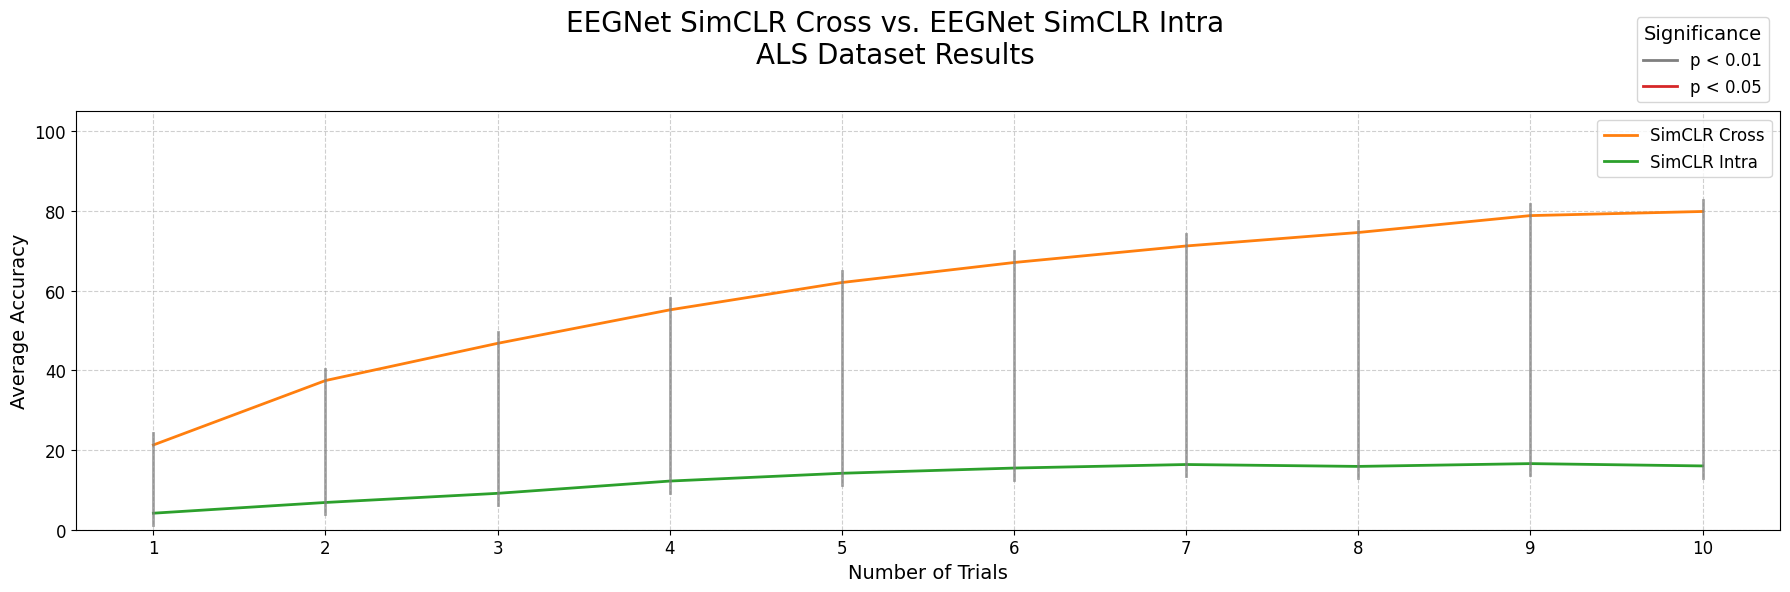

In [42]:
file_paths = [
    os.path.join(scripts_folder, 'CrossEvaluation/Baseline Results/EEGInception_results_ALS/EEGInception_50Folfd_evaluation_results_ALS.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/ALS Results/SimCLR_results/EEGInception_1CLS_50Folfd_evaluation_results.txt'),
]
plot_intra_cross(file_paths, 'EEGNet', retraining_chars=[1], dataset='ALS')

Analysing data from 1 Retraining Chars

N Trials -> 1

Is data Normally Distributed? - False
Is Variance Homogeneous? - True

Mann Whitney U Test results: (F-stat = 5082.0, p_value = 0.8414293317041498)

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - True

Mann Whitney U Test results: (F-stat = 5428.0, p_value = 0.2949675965840721)

N Trials -> 3

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Mann Whitney U Test results: (F-stat = 5318.5, p_value = 0.4364767844509946)

N Trials -> 4

Is data Normally Distributed? - False
Is Variance Homogeneous? - True

Mann Whitney U Test results: (F-stat = 5433.5, p_value = 0.28946937929839334)

N Trials -> 5

Is data Normally Distributed? - False
Is Variance Homogeneous? - True

Mann Whitney U Test results: (F-stat = 5392.0, p_value = 0.3383489117675701)

N Trials -> 6

Is data Normally Distributed? - False
Is Variance Homogeneous? - True

Mann Whitney U Test results: (F-stat = 5541.0, p_val

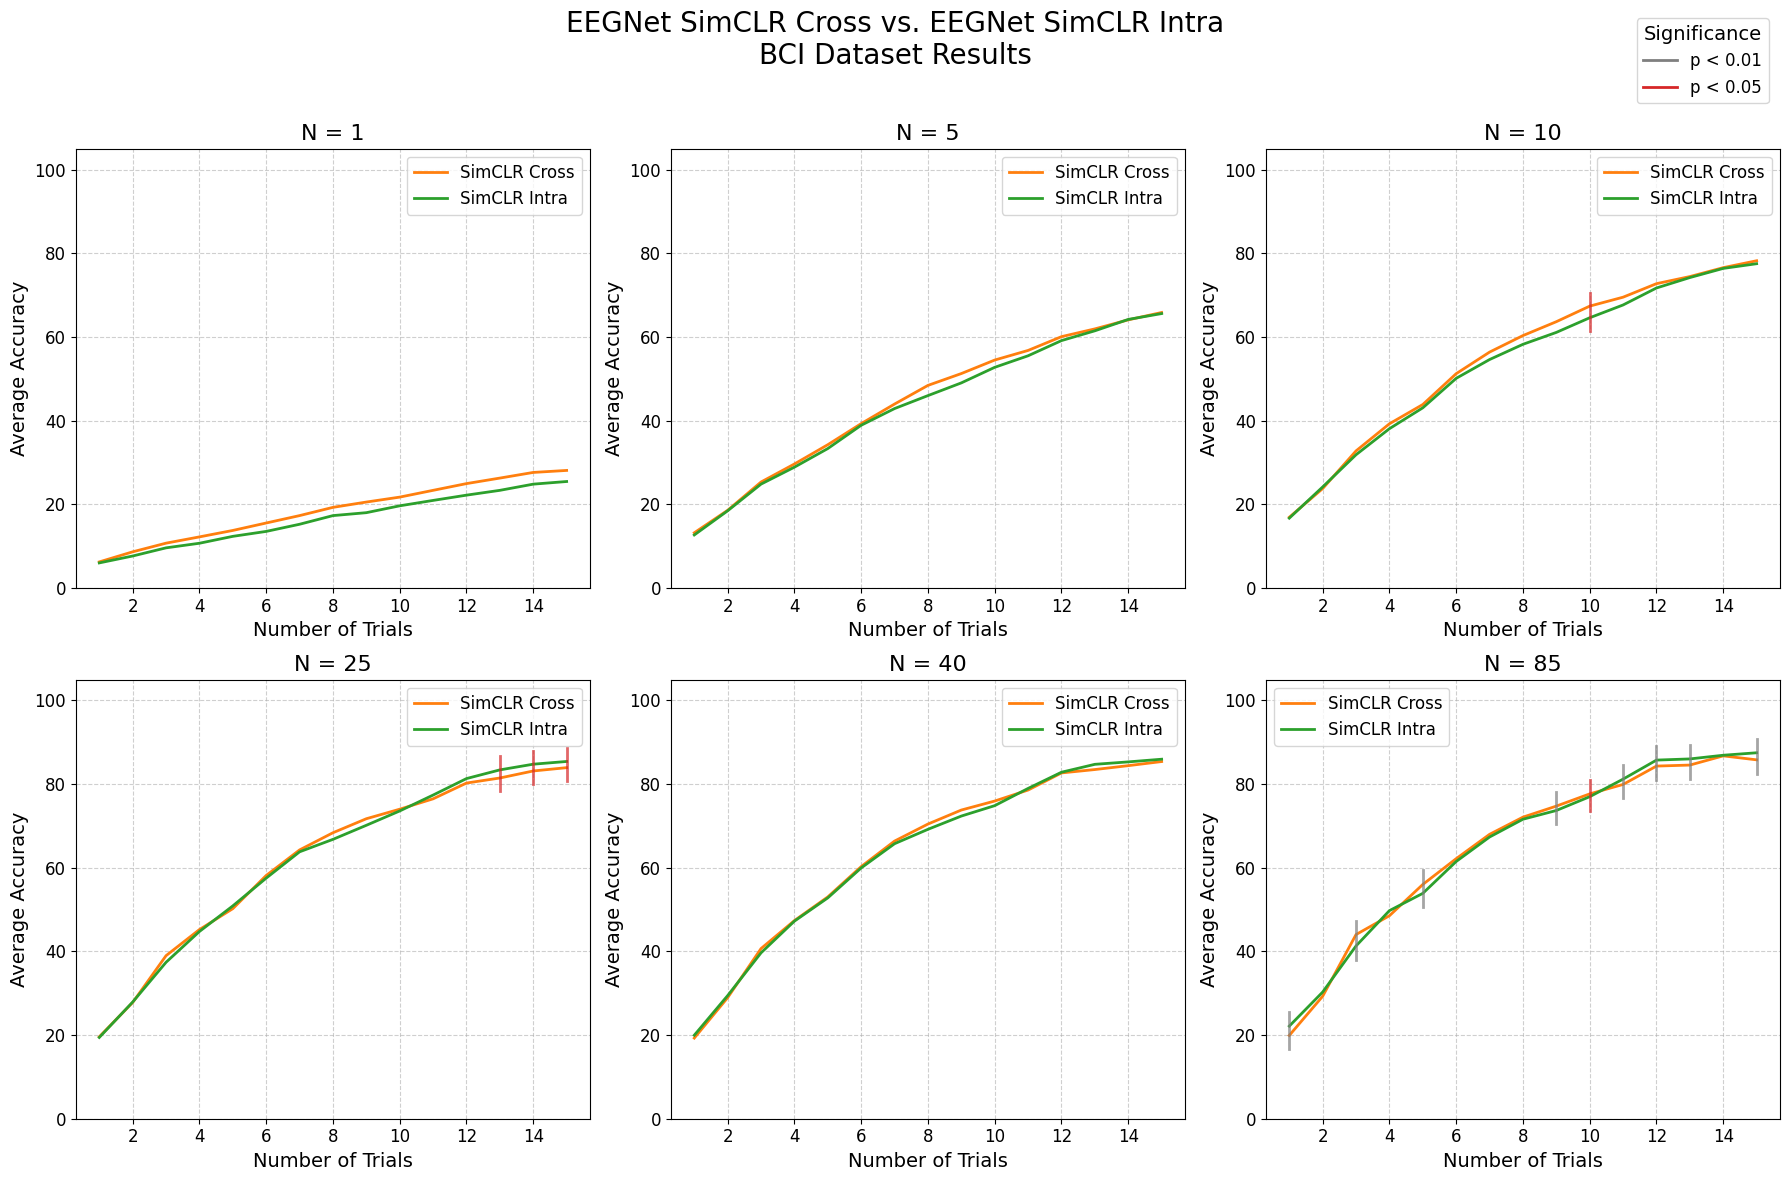

In [43]:
file_paths = [
    os.path.join(scripts_folder, 'CrossEvaluation/BCI Results/SimCLR_results/EEGNet_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/BCI Results/SimCLR_results/EEGNet_1CLS_INTRA_50Folfd_evaluation_results.txt'),
]
plot_intra_cross(file_paths, 'EEGNet', retraining_chars=[1, 5, 10, 25, 40, 85], dataset='BCI')

Analysing data from 1 Retraining Chars

N Trials -> 1

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Mann Whitney U Test results: (F-stat = 54209.0, p_value = 2.0248713762377727e-15)

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - True

Mann Whitney U Test results: (F-stat = 37780.5, p_value = 2.0644489559706962e-38)

N Trials -> 3

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Mann Whitney U Test results: (F-stat = 45550.5, p_value = 4.639733415443221e-26)

N Trials -> 4

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Mann Whitney U Test results: (F-stat = 52131.5, p_value = 1.3470937244218141e-17)

N Trials -> 5

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Mann Whitney U Test results: (F-stat = 43404.0, p_value = 3.5342528198954496e-29)

N Trials -> 6

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Mann Whitney U Test resul

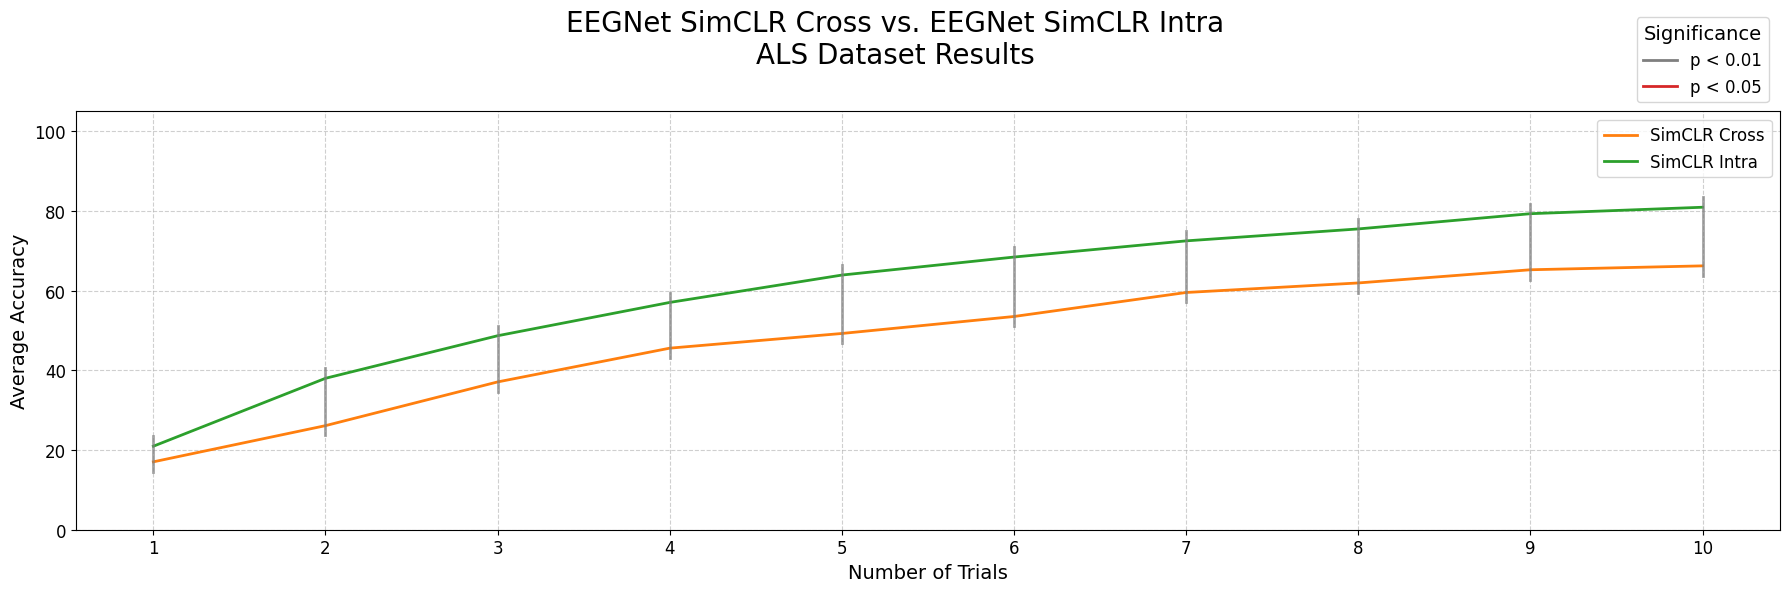

In [44]:
file_paths = [
    os.path.join(scripts_folder, 'CrossEvaluation/ALS Results/SimCLR_results/EEGNet_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/Baseline Results/EEGNet_results_ALS/EEGNet_50Folfd_evaluation_results_ALS.txt'),
]
plot_intra_cross(file_paths, 'EEGNet', retraining_chars=[1], dataset='ALS')

### Baseline Vs Studied

In [45]:
def plot_baseline_and_studied(file_paths: list, model_names: list, dataset = 'BCI'):
    # Setup the figure
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))
    palette = sns.color_palette(n_colors=8)
    blue, orange, green, red, purple, gray = palette[0], palette[1], palette[2], palette[3], palette[4], palette[7]

    model_colors = [blue, orange]

    for ax, idx in enumerate(range(0, len(file_paths), 2)):
        
        model_files = [file_paths[idx], file_paths[idx+1]]
        models = [model_names[idx], model_names[idx+1]]
        # Prepare data for statistical analysis
        all_data = {model_name: [] for model_name in models}
        trial_indices = range(1, 16) if dataset == 'BCI' else range(1,11)
        
        means = []
        
        ax2 = axes[ax].twinx()
        ax2.set_ylabel("ITR (bits/min)", fontsize=14, color='gray')
        ax2.set_ylim([0, 13])
        ax2.set_yticks(range(0, 13, 3))
        ax2.tick_params(axis='y', labelsize=12, colors='gray')
        ax2.grid(False)

        for file_path, model_name, color in zip(model_files, models, model_colors):
            if dataset == 'BCI':
                block = read_and_separate_blocks(file_path, dataset='BCI')
                # print(block)
                all_data[model_name] = block[85]  # Assuming block[85] holds the required accuracy data
            elif dataset == 'ALS':
                block = read_als_file(file_path)
                all_data[model_name] = block
            
            mean = np.mean(all_data[model_name], axis=0)
            means.append(mean)
            axes[ax].plot(trial_indices, mean, label=model_name, color=color, linewidth=2)
            
            itr_values = [compute_ITR(acc/100, trial+1, 'BCI') for trial, acc in enumerate(mean)]
            ax2.plot(trial_indices, itr_values, label=f'{model_name} ITR', color=color, linestyle='dotted')
            print(f'\n{model_name}: \nMean = {mean} \nITR = {itr_values}')
            # print(f'ITR = {itr_values}')

        trial_results = {trial-1: [np.array(all_data[model_name])[:, trial-1] for model_name in models] for trial in trial_indices}
        stat_results = []
        p_values = []

        # Loop through each trial to perform statistical tests
        for trial, data in trial_results.items():
            print(f'\nN Trials -> {trial+1}')
            trial_data = [d for d in data]

            # Check normality and homogeneity of variance.
            normality = all(shapiro(d).pvalue > 0.05 for d in trial_data)
            homogeneity = levene(*trial_data).pvalue > 0.05
            print(f'\nIs data Normally Distributed? - {normality}')
            print(f'Is Variance Homogeneous? - {homogeneity}')

            # Perform the Mann-Whitney U Test
            stat, p_value = mannwhitneyu(*trial_data, alternative='two-sided')
            print(f'\nMann Whitney U Test results: (F-stat = {stat}, p_value = {p_value})')
            stat_results.append((trial + 1, stat, p_value, "Mann Whitney U Test"))

            # Plot significance lines if p-value is less than 0.05 or 0.01
            if p_value < 0.05:
                # Find the values of the two models a this trial
                
                y_val_i = means[0][trial] 
                y_val_j = means[1][trial] 

                y_buffer = (max(means[0]) - min(means[0])) * 0.05
                
                # Set the line color based on p-value
                line_color = "gray" if p_value < 0.01 else "red"

                # Plot the significance line between the two models' values at this trial
                axes[ax].plot([trial+1, trial+1], [min(y_val_i, y_val_j) - y_buffer, max(y_val_i, y_val_j) + y_buffer], 
                            color=line_color, linestyle='-', alpha=0.7, linewidth=2)
            

        # Configure axis and title
        axes[ax].set_xlabel("Number of Trials", fontsize=14)
        axes[ax].set_ylabel("Average Accuracy", fontsize=14)
        axes[ax].set_ylim([0, 105])
        axes[ax].set_xticks(trial_indices)
        axes[ax].tick_params(axis='both', labelsize=12)
        axes[ax].grid(True, linestyle='--', alpha=0.6)
        axes[ax].legend(fontsize=12)
        axes[ax].set_title(f'{models[0]}', fontsize=18)

    red_line = Line2D([0], [0], color=red, lw=2, linestyle='-', label='p < 0.05')
    black_line = Line2D([0], [0], color=gray, lw=2, linestyle='-', label='p < 0.01')
    fig.legend(handles=[black_line, red_line], loc='upper right', fontsize=12, title="Significance", title_fontsize=14, bbox_to_anchor=(0.99, 0.99))
    
    plt.suptitle('Baseline vs. Pre-Trained Models Performance Comparison\n on the BCI Comp Dataset', fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.98]) 
    plt.show()


EEGNet: 
Mean = [20.49 31.64 42.16 51.69 56.55 64.25 68.89 72.55 75.3  77.89 80.58 84.04
 85.02 85.82 87.62] 
ITR = [4.695803121574699, 6.833942580450299, 8.324702220781841, 9.318124564418133, 9.016921046814174, 9.51901155840438, 9.348020628258915, 9.05934346487932, 8.681785729806155, 8.358305198627038, 8.117913105731947, 8.05329891031096, 7.635339920624805, 7.2482617481828715, 7.0495300056786565]

EEGNet SimCLR: 
Mean = [19.91 29.27 44.03 48.53 56.01 62.17 67.99 72.1  74.74 77.66 79.92 84.31
 84.55 86.75 85.8 ] 
ITR = [4.457710359442028, 5.998205388981012, 8.927547696214946, 8.424807117889308, 8.880003243103614, 9.030535328895859, 9.151923268109103, 8.968198072400691, 8.5763412102086, 8.317572226032645, 8.007280685773427, 8.097398504774636, 7.563348034172002, 7.384401638113438, 6.797848326914674]

N Trials -> 1

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Mann Whitney U Test results: (F-stat = 5067.5, p_value = 0.8695720127748714)

N Trials -> 2

Is data N

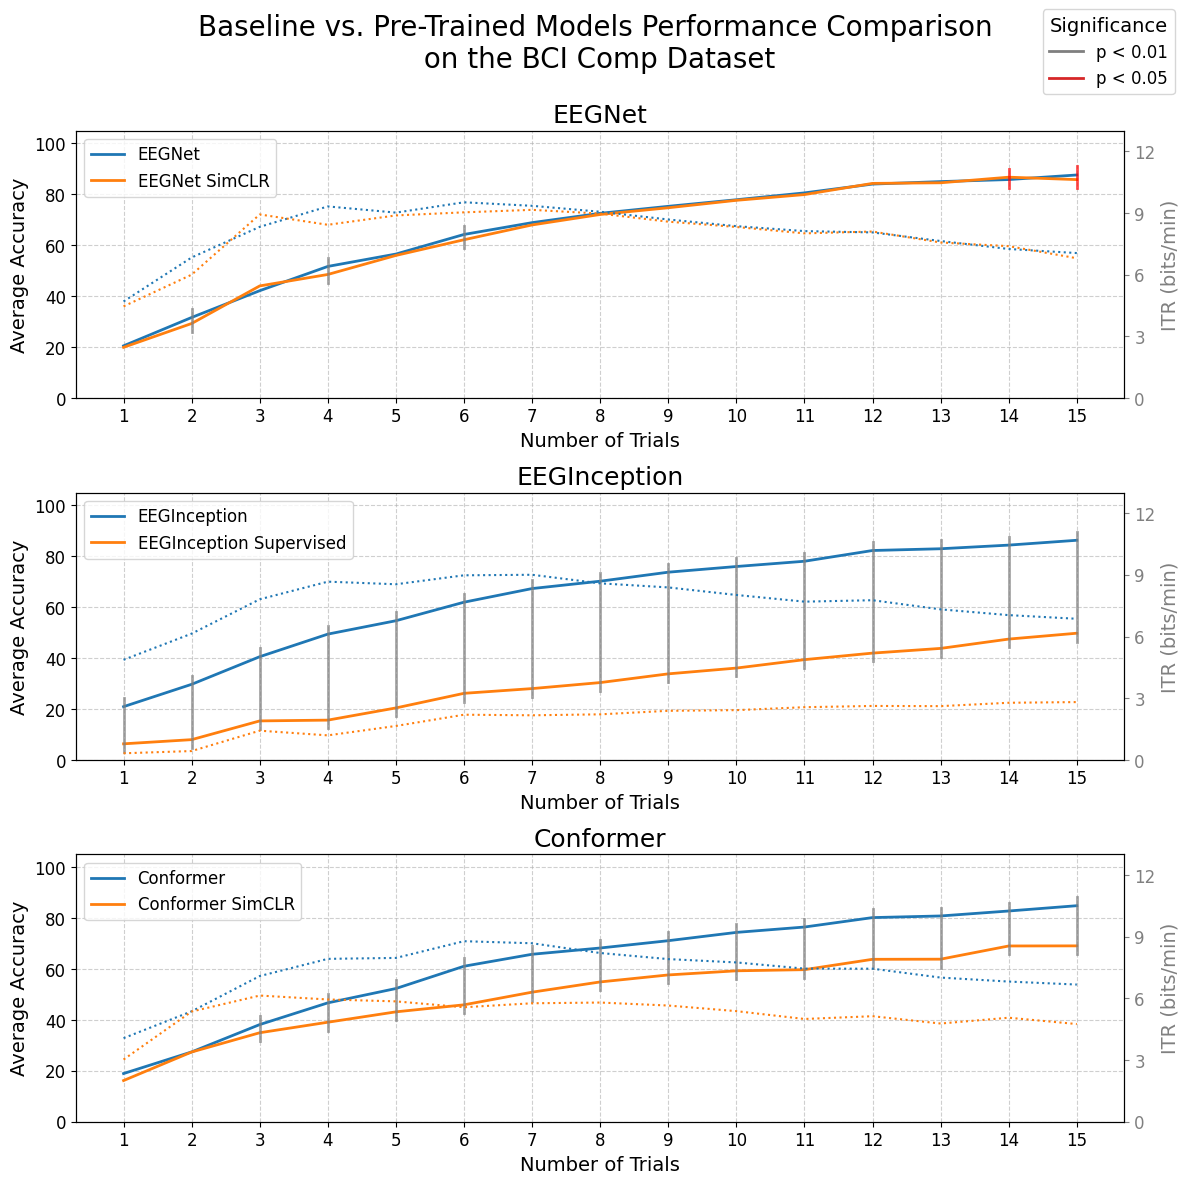

In [46]:
files = [
    os.path.join(scripts_folder, 'CrossEvaluation/Baseline Results/EEGNet_results/EEGNet_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/BCI Results/SimCLR_results/EEGNet_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/Baseline Results/EEGInception_results/EEGInception_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/BCI Results/Supervised_results/EEGInception_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/Baseline Results/Conformer_results/Conformer_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/BCI Results/SimCLR_results/Conformer_1CLS_50Folfd_evaluation_results.txt')  
]

model_names = ['EEGNet', 'EEGNet SimCLR', 'EEGInception', 'EEGInception Supervised', 'Conformer', 'Conformer SimCLR']

plot_baseline_and_studied(files, model_names)


EEGNet: 
Mean = [20.96025 38.00875 48.69025 57.052   63.92    68.44225 72.503   75.499
 79.3235  80.94225] 
ITR = [4.891699332267659, 9.24281682891212, 10.49043912337112, 10.90677652385526, 10.965851274319487, 10.53668158930289, 10.154720343195171, 9.668165077074338, 9.460136408634797, 8.909926172251732]

EEGNet SimCLR: 
Mean = [17.042   26.123   37.0965  45.5725  49.2585  53.52175 59.545   61.9395
 65.25075 66.22925] 
ITR = [3.340561781158262, 4.94299517127093, 6.7637474610368535, 7.617512269414886, 7.2341931248376685, 7.110618484506941, 7.3999657996652335, 7.023500656089608, 6.885221315470056, 6.421582033513383]

N Trials -> 1

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Mann Whitney U Test results: (F-stat = 105791.0, p_value = 2.0248713762377727e-15)

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - True

Mann Whitney U Test results: (F-stat = 122219.5, p_value = 2.0644489559706962e-38)

N Trials -> 3

Is data Normally Dis

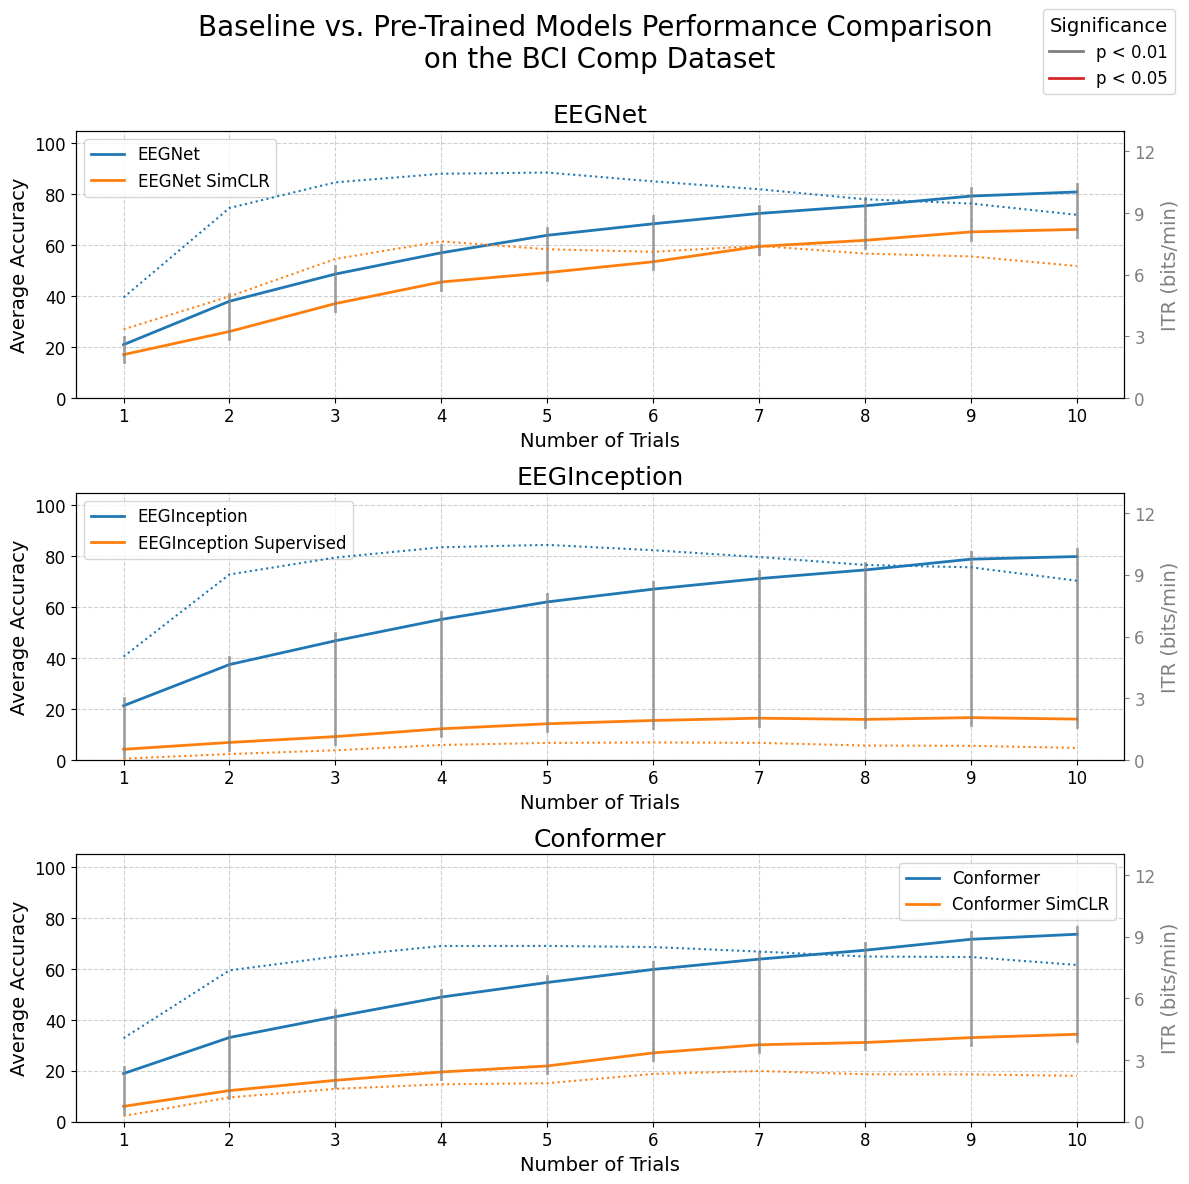

In [47]:
files = [
    os.path.join(scripts_folder, 'CrossEvaluation/Baseline Results/EEGNet_results_ALS/EEGNet_50Folfd_evaluation_results_ALS.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/ALS Results/SimCLR_results/EEGNet_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/Baseline Results/EEGInception_results_ALS/EEGInception_50Folfd_evaluation_results_ALS.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/ALS Results/SimCLR_results/EEGInception_1CLS_50Folfd_evaluation_results.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/Baseline Results/Conformer_results_ALS/Conformer_50Folfd_evaluation_results_ALS.txt'),
    os.path.join(scripts_folder, 'CrossEvaluation/ALS Results/SimCLR_results/Conformer_1CLS_50Folfd_evaluation_results.txt') 
]

model_names = ['EEGNet', 'EEGNet SimCLR', 'EEGInception', 'EEGInception Supervised', 'Conformer', 'Conformer SimCLR']

plot_baseline_and_studied(files, model_names, dataset='ALS')

### RASCUNHOS

Analysing data from 1 Retraining Chars

N Trials -> 1

Is data Normally Distributed? - False
Is Variance Homogeneous? - True

Friedman Test results: (F-stat = 4.7123287671233, p_value = 0.09478307839833659)

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - True

Friedman Test results: (F-stat = 6.25, p_value = 0.04393693362340742)
Post-hoc Wilcoxon tests for trial 2:
Wilcoxon test between Supervised and SimCLR: p-value = 0.2568832345824239
Wilcoxon test between Supervised and SupCon: p-value = 0.2754049172216797
Wilcoxon test between SimCLR and SupCon: p-value = 0.003487653294348727

N Trials -> 3

Is data Normally Distributed? - False
Is Variance Homogeneous? - True

Friedman Test results: (F-stat = 3.706666666666691, p_value = 0.15671391499593498)

N Trials -> 4

Is data Normally Distributed? - False
Is Variance Homogeneous? - True

Friedman Test results: (F-stat = 10.459459459459472, p_value = 0.005354972396934794)
Post-hoc Wilcoxon tests for trial 4:


ValueError: Data must be at least length 3.

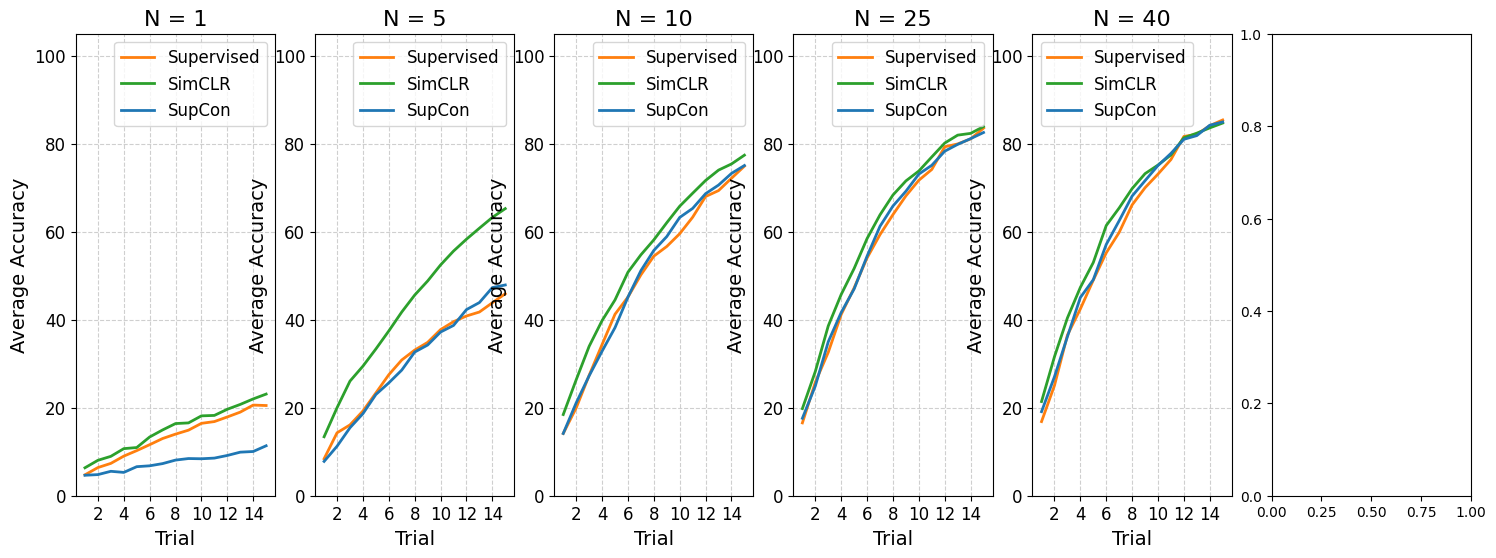

In [7]:
file_paths = [
    '/workspace/project/GitHub/Scripts/CrossDatasetEval/BCI COMP DATASET/Supervised_results/EEGNet_1CLS_Round2_evaluation_results.txt',
    '/workspace/project/GitHub/Scripts/CrossDatasetEval/BCI COMP DATASET/SimCLR_results/EEGNet_1CLS_Round2_evaluation_results.txt',
    '/workspace/project/GitHub/Scripts/CrossDatasetEval/BCI COMP DATASET/SupCon_results/EEGNet_1CLS_Round2_evaluation_results.txt'
]
statistical_analysis_Intra(file_paths, 'EEGNet_1CLS', retraining_chars=[1, 5, 10, 25, 40, 85], dataset='BCI')

Analysing data from 1 Retraining Chars

N Trials -> 1

Is data Normally Distributed? - True
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 8.240000000000025, p_value = 0.016244514441949666)
Post-hoc Wilcoxon tests for trial 1:
Wilcoxon test between Supervised and SimCLR: p-value = 0.0072956085205078125
Wilcoxon test between Supervised and SupCon: p-value = 0.45918090325585803
Wilcoxon test between SimCLR and SupCon: p-value = 0.012825694558451565

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 7.802816901408464, p_value = 0.020213421779228677)
Post-hoc Wilcoxon tests for trial 2:
Wilcoxon test between Supervised and SimCLR: p-value = 0.01474410073152252
Wilcoxon test between Supervised and SupCon: p-value = 0.7527247987155536
Wilcoxon test between SimCLR and SupCon: p-value = 0.005358400752356843

N Trials -> 3

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Te

ValueError: Data must be at least length 3.

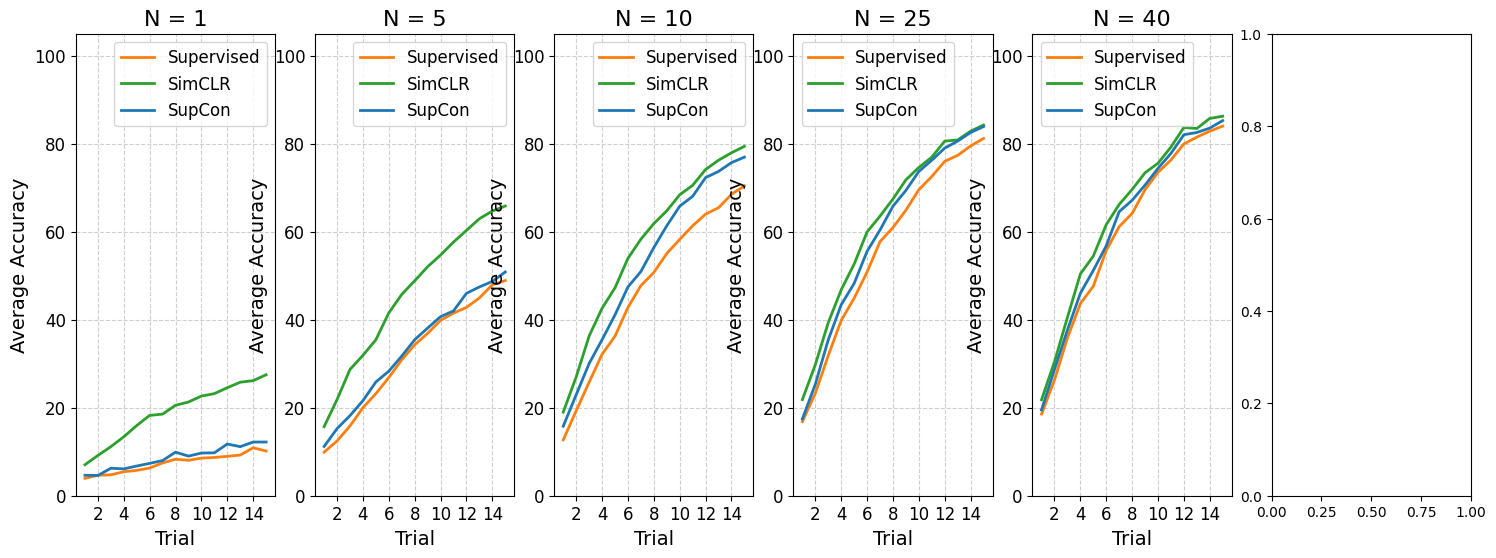

In [7]:
file_paths = [
    '/workspace/project/GitHub/Scripts/CrossDatasetEval/BCI COMP DATASET/Supervised_results/EEGNet_1CLS_Intra_evaluation_results.txt',
    '/workspace/project/GitHub/Scripts/CrossDatasetEval/BCI COMP DATASET/SimCLR_results/EEGNet_1CLS_Intra_evaluation_results.txt',
    '/workspace/project/GitHub/Scripts/CrossDatasetEval/BCI COMP DATASET/SupCon_results/EEGNet_1CLS_Intra_evaluation_results.txt'
]
statistical_analysis_Intra(file_paths, 'EEGNet_Intra', retraining_chars=[1, 5, 10, 25, 40, 85], dataset='BCI')

Analysing data from 1 Retraining Chars

N Trials -> 1

Is data Normally Distributed? - False
Is Variance Homogeneous? - True

Friedman Test results: (F-stat = 1.6944444444444506, p_value = 0.4286038461538355)

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - True

Friedman Test results: (F-stat = 6.5757575757575895, p_value = 0.03733295658501832)
Post-hoc Wilcoxon tests for trial 2:
Wilcoxon test between Supervised and SimCLR: p-value = 0.02443244066331195
Wilcoxon test between Supervised and SupCon: p-value = 0.04482746245815838
Wilcoxon test between SimCLR and SupCon: p-value = 0.7087820813050039

N Trials -> 3

Is data Normally Distributed? - False
Is Variance Homogeneous? - True

Friedman Test results: (F-stat = 10.19178082191782, p_value = 0.0061218532421141204)
Post-hoc Wilcoxon tests for trial 3:
Wilcoxon test between Supervised and SimCLR: p-value = 0.010531201418704375
Wilcoxon test between Supervised and SupCon: p-value = 0.0026683448500304688
W

ValueError: Data must be at least length 3.

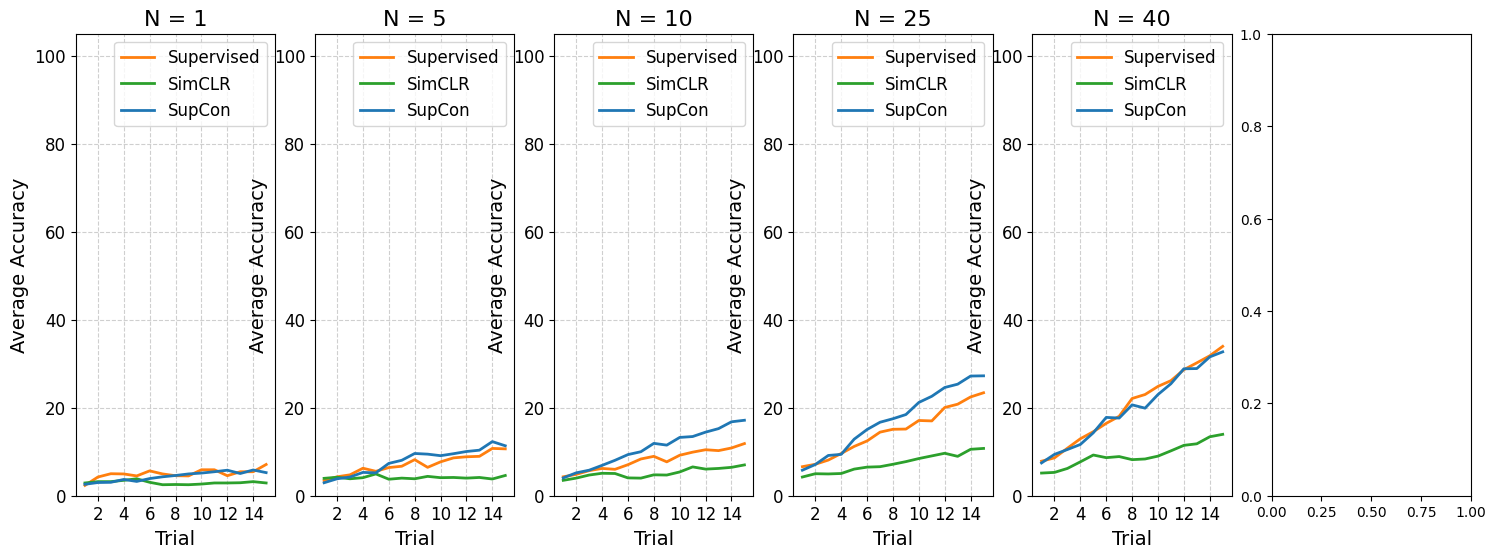

In [8]:
file_paths = [
    '/workspace/project/GitHub/Scripts/CrossDatasetEval/BCI COMP DATASET/Supervised_results/EEGInception_1CLS_evaluation_results.txt',
    '/workspace/project/GitHub/Scripts/CrossDatasetEval/BCI COMP DATASET/SimCLR_results/EEGInception_1CLS_evaluation_results.txt',
    '/workspace/project/GitHub/Scripts/CrossDatasetEval/BCI COMP DATASET/SupCon_results/EEGInception_1CLS_evaluation_results.txt'
]
statistical_analysis_Intra(file_paths, 'EEGInception_1CLS', retraining_chars=[1, 5, 10, 25, 40, 85], dataset='BCI')

Analysing data from 1 Retraining Chars

N Trials -> 1

Is data Normally Distributed? - True
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 0.8611111111111174, p_value = 0.6501478011504199)

N Trials -> 2

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 1.8356164383561768, p_value = 0.3993934653990971)

N Trials -> 3

Is data Normally Distributed? - True
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 5.189189189189201, p_value = 0.07467614405107305)

N Trials -> 4

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 2.9210526315789536, p_value = 0.23211407727152597)

N Trials -> 5

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test results: (F-stat = 0.7200000000000121, p_value = 0.6976763260710268)

N Trials -> 6

Is data Normally Distributed? - False
Is Variance Homogeneous? - False

Friedman Test resul

ValueError: Data must be at least length 3.

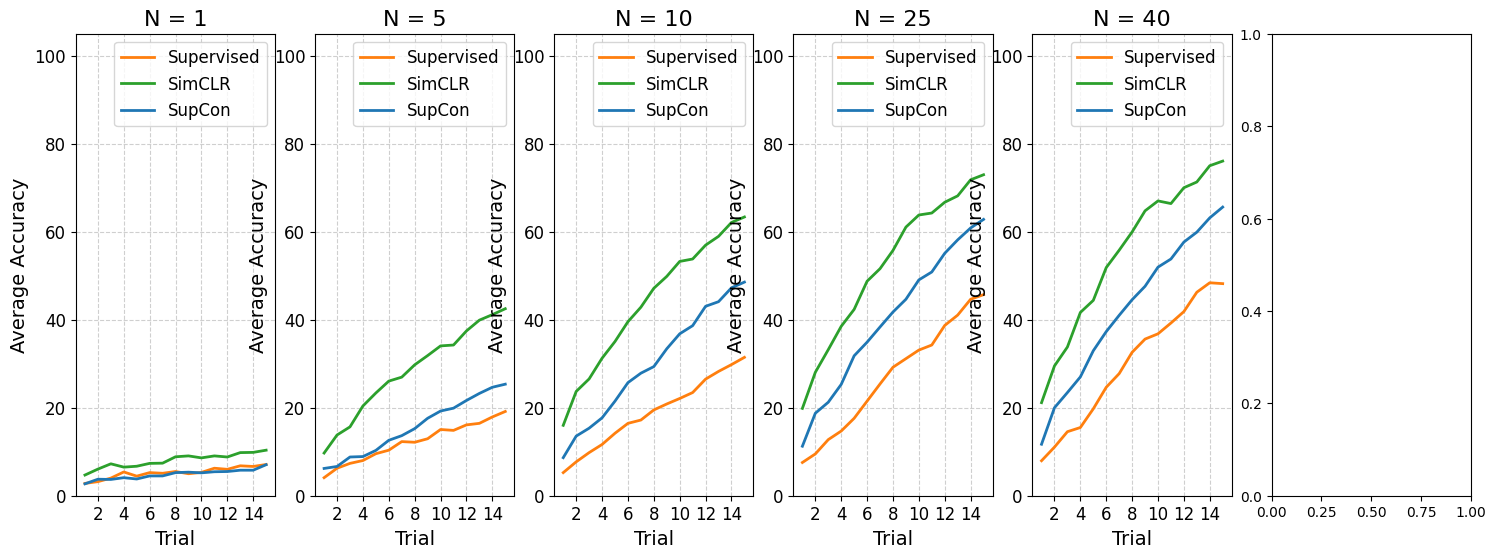

In [9]:
file_paths = [
    '/workspace/project/GitHub/Scripts/CrossDatasetEval/BCI COMP DATASET/Supervised_results/Conformer_1CLS_evaluation_results.txt',
    '/workspace/project/GitHub/Scripts/CrossDatasetEval/BCI COMP DATASET/SimCLR_results/Conformer_1CLS_evaluation_results.txt',
    '/workspace/project/GitHub/Scripts/CrossDatasetEval/BCI COMP DATASET/SupCon_results/Conformer_1CLS_evaluation_results.txt'
]
statistical_analysis_Intra(file_paths, 'Conformer_1CLS', retraining_chars=[1, 5, 10, 25, 40, 85], dataset='BCI')

In [167]:
from scipy.stats import shapiro, levene, friedmanchisquare, wilcoxon
import itertools

def analyse_bci_results(models, model_names):
    # Compute means and standard deviations across trials for each model.
    mean_values = [np.mean(model, axis=0) for model in models]
    std_values = [np.std(model, axis=0) for model in models]

    for mean, std, model in zip(mean_values, std_values, model_names):
        print(f'\n{model} mean accuracy -> {list(mean)}')
        print(f'{model} std variation -> {list(np.round(std, 2))}')
        
    # Combine data for each trial across models.
    trial_results = {trial: [np.array(model)[:, trial] for model in models] for trial in range(15)}

    # Perform statistical analysis for each trial.
    friedman_results = []
    for trial, data in trial_results.items():
        # Combine data across folds for each model.
        trial_data = [d for d in data]

        # Check normality and homogeneity of variance.
        normality = all(shapiro(d).pvalue > 0.05 for d in trial_data)
        homogeneity = levene(*trial_data).pvalue > 0.05

        # Perform Friedman test.
        f_stat, p_value = friedmanchisquare(*trial_data)
        method = "Friedman Test"

        # Store the results.
        friedman_results.append((trial + 1, f_stat, p_value, method))

        # If Friedman test is significant, perform pairwise Wilcoxon signed-rank tests.
        if p_value < 0.05:
            p_values = []
            pairs = list(itertools.combinations(range(len(trial_data)), 2))  # Generate pairs of trials
            
            for (i, j) in pairs:
                stat, p_value_wilcoxon = wilcoxon(trial_data[i], trial_data[j])
                p_values.append((i, j, p_value_wilcoxon))
            
            print(f"Post-hoc Wilcoxon tests for trial {trial + 1}:")
            for (i, j, p_value) in p_values:
                print(f"Wilcoxon test between {model_names[i]} and {model_names[j]}: p-value = {p_value}")

    # Display results
    print("Trial-wise Statistical Analysis:")
    print(f"{'Trial':<8}{'Test':<20}{'F-statistic':<15}{'P-value':<15}{'Significant':<10}")
    for trial, f_stat, p_value, method in friedman_results:
        significance = "Yes" if p_value < 0.05 else "No"
        print(f"{trial:<8}{method:<20}{f_stat:<15.2f}{p_value:<15.4f}{significance:<10}")

    # Plot results
    plt.figure(figsize=(10, 6))
    trials = np.arange(1, 16)

    for i, model in enumerate(models):
        # Compute mean and std for each trial.
        means = np.mean(np.concatenate(model, axis=0).reshape(-1, 15), axis=0)
        stds = np.std(np.concatenate(model, axis=0).reshape(-1, 15), axis=0)
        plt.plot(trials, means, label=model_names[i])
        plt.fill_between(trials, means - stds, means + stds, alpha=0.2)

    # Highlight significant trials.
    for trial, _, p_value, _ in friedman_results:
        if p_value < 0.05:
            plt.axvline(x=trial, color='red', linestyle='--', alpha=0.5)

    plt.title("Performance Across Trials with Statistical Significance")
    plt.xlabel("Trial Number")
    plt.ylabel("Performance Metric")
    plt.legend()
    plt.grid(True)
    plt.show()

In [1]:

eegnet = [
[10.0, 22.0, 28.0, 36.0, 46.0, 57.0, 61.0, 65.0, 68.0, 70.0, 74.0, 79.0, 81.0, 81.0, 84.0],
[13.0, 19.0, 31.0, 33.0, 43.0, 54.0, 57.0, 59.0, 63.0, 68.0, 70.0, 78.0, 80.0, 80.0, 84.0],
[9.0, 19.0, 27.0, 37.0, 39.0, 53.0, 58.0, 63.0, 64.0, 70.0, 72.0, 79.0, 82.0, 81.0, 82.0],
[10.0, 19.0, 28.0, 36.0, 41.0, 55.0, 56.0, 63.0, 65.0, 68.0, 69.0, 78.0, 79.0, 80.0, 82.0],
[14.0, 20.0, 29.0, 39.0, 44.0, 55.0, 59.0, 61.0, 68.0, 71.0, 71.0, 80.0, 81.0, 84.0, 86.0],
[26.0, 43.0, 56.0, 63.0, 66.0, 76.0, 81.0, 83.0, 86.0, 89.0, 94.0, 94.0, 93.0, 92.0, 92.0],
[28.0, 48.0, 56.0, 69.0, 68.0, 76.0, 79.0, 81.0, 83.0, 83.0, 86.0, 87.0, 85.0, 86.0, 89.0],
[30.0, 42.0, 56.0, 66.0, 70.0, 76.0, 75.0, 78.0, 85.0, 85.0, 87.0, 91.0, 92.0, 91.0, 91.0],
[32.0, 40.0, 56.0, 66.0, 67.0, 73.0, 77.0, 77.0, 84.0, 83.0, 86.0, 90.0, 90.0, 92.0, 91.0],
[30.0, 41.0, 50.0, 66.0, 73.0, 75.0, 80.0, 84.0, 83.0, 85.0, 87.0, 89.0, 90.0, 89.0, 91.0],
]

eeginception = [
[10.0, 18.0, 26.0, 33.0, 39.0, 47.0, 49.0, 57.0, 61.0, 63.0, 68.0, 77.0, 78.0, 77.0, 81.0],
[13.0, 18.0, 23.0, 33.0, 43.0, 51.0, 57.0, 61.0, 63.0, 66.0, 68.0, 76.0, 79.0, 80.0, 82.0],
[13.0, 20.0, 28.0, 32.0, 44.0, 54.0, 56.0, 57.0, 64.0, 67.0, 69.0, 80.0, 81.0, 79.0, 79.0],
[14.0, 18.0, 30.0, 34.0, 38.0, 51.0, 53.0, 58.0, 62.0, 66.0, 65.0, 75.0, 80.0, 79.0, 78.0],
[13.0, 19.0, 30.0, 34.0, 40.0, 51.0, 59.0, 63.0, 63.0, 67.0, 71.0, 78.0, 77.0, 78.0, 77.0],
[28.0, 38.0, 55.0, 63.0, 68.0, 76.0, 84.0, 86.0, 87.0, 91.0, 90.0, 92.0, 93.0, 94.0, 96.0],
[27.0, 42.0, 52.0, 66.0, 67.0, 75.0, 82.0, 82.0, 83.0, 85.0, 86.0, 90.0, 91.0, 91.0, 92.0],
[32.0, 41.0, 50.0, 59.0, 65.0, 70.0, 76.0, 76.0, 82.0, 83.0, 84.0, 91.0, 86.0, 89.0, 92.0],
[27.0, 40.0, 52.0, 56.0, 62.0, 65.0, 78.0, 85.0, 81.0, 88.0, 91.0, 90.0, 92.0, 92.0, 91.0],
[30.0, 39.0, 56.0, 68.0, 71.0, 80.0, 83.0, 85.0, 88.0, 89.0, 89.0, 89.0, 91.0, 93.0, 94.0],
]

# eegnet = [
# [4.0, 10.0, 15.0, 20.0, 28.0, 32.0, 42.0, 42.0, 45.0, 55.0, 58.0, 60.0, 62.0, 69.0, 69.0],
# [11.0, 15.0, 28.0, 31.0, 33.0, 39.0, 45.0, 52.0, 58.0, 59.0, 62.0, 72.0, 69.0, 72.0, 75.0],
# [10.0, 15.0, 21.0, 26.0, 28.0, 34.0, 43.0, 47.0, 48.0, 48.0, 59.0, 66.0, 66.0, 68.0, 68.0],
# [8.0, 14.0, 21.0, 33.0, 35.0, 33.0, 39.0, 45.0, 53.0, 59.0, 60.0, 65.0, 71.0, 74.0, 81.0],
# [10.0, 9.0, 20.0, 23.0, 33.0, 38.0, 46.0, 51.0, 56.0, 60.0, 59.0, 68.0, 70.0, 73.0, 76.0],
# [29.0, 34.0, 50.0, 60.0, 61.0, 66.0, 72.0, 76.0, 78.0, 79.0, 83.0, 81.0, 86.0, 86.0, 88.0],
# [24.0, 37.0, 46.0, 51.0, 56.0, 65.0, 70.0, 74.0, 72.0, 76.0, 78.0, 80.0, 84.0, 84.0, 87.0],
# [27.0, 36.0, 47.0, 53.0, 59.0, 66.0, 69.0, 69.0, 77.0, 75.0, 78.0, 80.0, 82.0, 88.0, 87.0],
# [28.0, 42.0, 45.0, 52.0, 60.0, 65.0, 65.0, 76.0, 74.0, 77.0, 81.0, 86.0, 85.0, 85.0, 87.0],
# [22.0, 33.0, 51.0, 62.0, 66.0, 70.0, 73.0, 75.0, 80.0, 81.0, 83.0, 85.0, 87.0, 86.0, 87.0],
# ]

eegnet_original = [
[15.0, 20.0, 30.0, 37.0, 47.0, 49.0, 57.0, 60.0, 68.0, 69.0, 72.0, 76.0, 79.0, 82.0, 81.0],
[13.0, 17.0, 24.0, 42.0, 47.0, 53.0, 55.0, 59.0, 63.0, 66.0, 73.0, 81.0, 84.0, 84.0, 86.0],
[12.0, 20.0, 31.0, 42.0, 48.0, 52.0, 53.0, 59.0, 64.0, 65.0, 73.0, 78.0, 81.0, 83.0, 88.0],
[13.0, 15.0, 30.0, 39.0, 46.0, 53.0, 57.0, 60.0, 64.0, 66.0, 73.0, 78.0, 83.0, 82.0, 83.0],
[18.0, 20.0, 28.0, 40.0, 46.0, 54.0, 59.0, 62.0, 67.0, 68.0, 70.0, 81.0, 81.0, 80.0, 84.0],
[26.0, 43.0, 56.0, 67.0, 67.0, 77.0, 79.0, 82.0, 86.0, 89.0, 89.0, 89.0, 86.0, 90.0, 93.0],
[30.0, 44.0, 56.0, 64.0, 68.0, 79.0, 82.0, 85.0, 87.0, 89.0, 89.0, 92.0, 89.0, 91.0, 92.0],
[22.0, 46.0, 59.0, 65.0, 71.0, 77.0, 81.0, 83.0, 84.0, 88.0, 89.0, 89.0, 90.0, 90.0, 90.0],
[29.0, 42.0, 52.0, 63.0, 68.0, 76.0, 81.0, 78.0, 84.0, 84.0, 90.0, 90.0, 90.0, 91.0, 91.0],
[24.0, 42.0, 56.0, 67.0, 72.0, 76.0, 81.0, 84.0, 86.0, 90.0, 92.0, 91.0, 89.0, 92.0, 92.0],
]

eeginception = [
[13.0, 15.0, 24.0, 33.0, 34.0, 44.0, 52.0, 50.0, 54.0, 61.0, 58.0, 66.0, 71.0, 71.0, 76.0],
[11.0, 11.0, 17.0, 30.0, 34.0, 44.0, 50.0, 55.0, 58.0, 64.0, 64.0, 67.0, 67.0, 67.0, 73.0],
[15.0, 13.0, 19.0, 29.0, 41.0, 44.0, 49.0, 54.0, 55.0, 64.0, 64.0, 72.0, 73.0, 75.0, 75.0],
[11.0, 13.0, 21.0, 27.0, 38.0, 37.0, 43.0, 43.0, 51.0, 59.0, 58.0, 64.0, 68.0, 68.0, 69.0],
[10.0, 14.0, 22.0, 23.0, 32.0, 40.0, 40.0, 43.0, 49.0, 60.0, 60.0, 65.0, 67.0, 72.0, 72.0],
[27.0, 31.0, 45.0, 55.0, 59.0, 61.0, 70.0, 67.0, 74.0, 75.0, 78.0, 82.0, 86.0, 86.0, 87.0],
[20.0, 39.0, 47.0, 59.0, 62.0, 70.0, 74.0, 76.0, 72.0, 78.0, 82.0, 81.0, 82.0, 83.0, 86.0],
[30.0, 36.0, 51.0, 58.0, 63.0, 69.0, 75.0, 73.0, 78.0, 80.0, 87.0, 85.0, 88.0, 90.0, 90.0],
[20.0, 44.0, 52.0, 55.0, 59.0, 68.0, 72.0, 75.0, 72.0, 75.0, 79.0, 84.0, 85.0, 87.0, 85.0],
[24.0, 32.0, 48.0, 58.0, 59.0, 69.0, 67.0, 74.0, 75.0, 76.0, 79.0, 82.0, 84.0, 87.0, 89.0],
]

eeginception_original = [
[17.0, 18.0, 30.0, 43.0, 42.0, 51.0, 56.0, 54.0, 65.0, 67.0, 69.0, 75.0, 77.0, 78.0, 81.0],
[16.0, 19.0, 28.0, 37.0, 43.0, 52.0, 60.0, 60.0, 61.0, 68.0, 69.0, 76.0, 77.0, 78.0, 82.0],
[13.0, 14.0, 29.0, 34.0, 41.0, 51.0, 57.0, 59.0, 62.0, 69.0, 71.0, 73.0, 75.0, 80.0, 80.0],
[12.0, 13.0, 27.0, 37.0, 46.0, 50.0, 57.0, 58.0, 59.0, 63.0, 65.0, 72.0, 75.0, 76.0, 78.0],
[15.0, 14.0, 28.0, 36.0, 44.0, 53.0, 59.0, 57.0, 65.0, 69.0, 70.0, 77.0, 81.0, 80.0, 81.0],
[36.0, 40.0, 58.0, 63.0, 71.0, 78.0, 80.0, 85.0, 86.0, 88.0, 92.0, 91.0, 91.0, 91.0, 93.0],
[32.0, 38.0, 54.0, 62.0, 69.0, 77.0, 85.0, 87.0, 88.0, 90.0, 93.0, 92.0, 92.0, 93.0, 92.0],
[30.0, 43.0, 55.0, 59.0, 66.0, 78.0, 82.0, 85.0, 87.0, 85.0, 90.0, 91.0, 90.0, 92.0, 93.0],
[28.0, 46.0, 60.0, 65.0, 71.0, 78.0, 87.0, 86.0, 90.0, 91.0, 93.0, 92.0, 93.0, 94.0, 93.0],
[33.0, 45.0, 55.0, 66.0, 69.0, 76.0, 79.0, 83.0, 82.0, 87.0, 89.0, 92.0, 90.0, 90.0, 92.0],
]

conformer = [
[11.0, 13.0, 21.0, 23.0, 33.0, 42.0, 50.0, 56.0, 58.0, 61.0, 62.0, 63.0, 66.0, 74.0, 76.0],
[12.0, 12.0, 21.0, 27.0, 33.0, 41.0, 44.0, 48.0, 53.0, 54.0, 63.0, 67.0, 71.0, 73.0, 75.0],
[10.0, 13.0, 23.0, 28.0, 31.0, 34.0, 37.0, 40.0, 46.0, 50.0, 54.0, 58.0, 58.0, 64.0, 66.0],
[12.0, 20.0, 26.0, 32.0, 38.0, 47.0, 48.0, 54.0, 56.0, 59.0, 63.0, 69.0, 73.0, 75.0, 78.0],
[10.0, 12.0, 23.0, 27.0, 31.0, 43.0, 53.0, 52.0, 57.0, 61.0, 63.0, 69.0, 70.0, 76.0, 80.0],
[21.0, 44.0, 45.0, 62.0, 65.0, 70.0, 75.0, 79.0, 80.0, 81.0, 79.0, 81.0, 83.0, 87.0, 86.0],
[30.0, 39.0, 47.0, 60.0, 62.0, 73.0, 75.0, 79.0, 77.0, 83.0, 82.0, 83.0, 84.0, 91.0, 90.0],
[27.0, 34.0, 45.0, 57.0, 61.0, 73.0, 77.0, 82.0, 85.0, 85.0, 85.0, 88.0, 86.0, 94.0, 95.0],
[23.0, 41.0, 46.0, 55.0, 58.0, 68.0, 71.0, 72.0, 76.0, 78.0, 81.0, 86.0, 84.0, 83.0, 85.0],
[21.0, 31.0, 48.0, 55.0, 55.0, 63.0, 71.0, 72.0, 75.0, 75.0, 75.0, 81.0, 81.0, 82.0, 86.0],
]

eegwrn = [
[11.0, 15.0, 20.0, 29.0, 33.0, 40.0, 47.0, 49.0, 55.0, 61.0, 62.0, 64.0, 63.0, 68.0, 69.0],
[12.0, 14.0, 29.0, 34.0, 47.0, 50.0, 53.0, 53.0, 56.0, 65.0, 62.0, 66.0, 70.0, 75.0, 73.0],
[14.0, 17.0, 26.0, 31.0, 43.0, 46.0, 50.0, 51.0, 52.0, 57.0, 57.0, 64.0, 67.0, 72.0, 75.0],
[10.0, 9.0, 21.0, 29.0, 34.0, 40.0, 46.0, 49.0, 56.0, 61.0, 66.0, 72.0, 75.0, 77.0, 77.0],
[10.0, 15.0, 27.0, 32.0, 37.0, 39.0, 42.0, 50.0, 49.0, 54.0, 55.0, 62.0, 66.0, 70.0, 70.0],
[24.0, 40.0, 46.0, 66.0, 71.0, 74.0, 81.0, 81.0, 82.0, 86.0, 90.0, 92.0, 92.0, 92.0, 92.0],
[21.0, 34.0, 46.0, 52.0, 61.0, 74.0, 73.0, 73.0, 76.0, 80.0, 83.0, 84.0, 87.0, 88.0, 91.0],
[28.0, 39.0, 51.0, 63.0, 65.0, 65.0, 73.0, 79.0, 80.0, 81.0, 80.0, 84.0, 86.0, 89.0, 90.0],
[24.0, 35.0, 50.0, 60.0, 62.0, 71.0, 78.0, 81.0, 82.0, 81.0, 82.0, 84.0, 88.0, 88.0, 90.0],
[23.0, 33.0, 47.0, 64.0, 63.0, 70.0, 72.0, 74.0, 74.0, 80.0, 80.0, 80.0, 83.0, 85.0, 89.0],
]


EEGNet mean accuracy -> [20.2, 31.3, 41.7, 51.1, 55.7, 65.0, 68.3, 71.4, 74.9, 77.2, 79.6, 84.5, 85.3, 85.6, 87.2]
EEGNet std variation -> [9.22, 11.7, 13.24, 15.02, 13.33, 10.28, 10.29, 9.51, 9.45, 8.0, 8.75, 5.95, 5.14, 4.8, 3.82]

EEGInception mean accuracy -> [20.7, 29.3, 40.2, 47.8, 53.7, 62.0, 67.7, 71.0, 73.4, 76.5, 78.1, 83.8, 84.8, 85.2, 86.2]
EEGInception std variation -> [8.27, 10.76, 13.03, 14.94, 13.18, 11.89, 13.31, 12.2, 11.0, 10.94, 10.16, 6.75, 6.13, 6.75, 7.04]

Conformer mean accuracy -> [17.7, 25.9, 34.5, 42.6, 46.7, 55.4, 60.1, 63.4, 66.3, 68.7, 70.7, 74.5, 75.6, 79.9, 81.7]
Conformer std variation -> [7.18, 12.54, 11.8, 15.46, 13.84, 14.55, 14.35, 14.28, 12.93, 12.35, 10.29, 9.96, 8.91, 8.72, 7.96]

EEGWRN mean accuracy -> [17.7, 25.1, 36.3, 46.0, 51.6, 56.9, 61.5, 64.0, 66.2, 70.6, 71.7, 75.2, 77.7, 80.4, 81.6]
EEGWRN std variation -> [6.59, 11.43, 12.05, 15.45, 13.59, 14.42, 14.36, 13.86, 12.95, 11.43, 11.93, 10.28, 10.14, 8.48, 9.08]
Post-hoc Wilcoxon tests fo

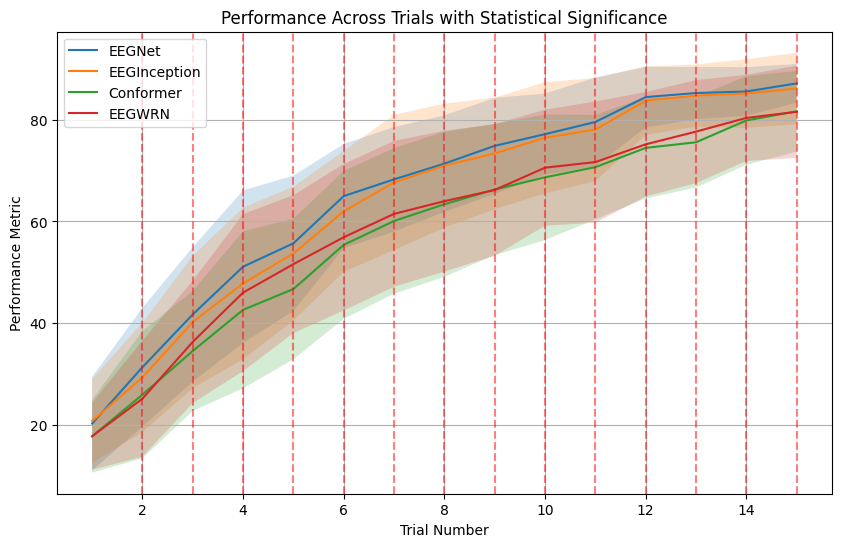

In [7]:
models = [eegnet, eeginception, conformer, eegwrn]
model_names = ["EEGNet", "EEGInception", "Conformer", "EEGWRN"]

analyse_bci_results(models, model_names)